# IMPORTS AND STATIC STUFF

In [1]:
from utilities import *
import torch
import torch.nn as nn
#import mlflow
import pandas as pd
import math
from torch.nn import CrossEntropyLoss, Softmax, BatchNorm1d, BCEWithLogitsLoss, Sigmoid
import pickle
from scipy import stats
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.optim import Adam
from pathlib import Path
import random
import warnings

#ignore warning for computing mcc of 0.0
warnings.filterwarnings("ignore", category=RuntimeWarning)

### SETTING SEEDS ###
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "Data"  
BEPIPRED3_NON_HOM_REDUCED = DATA_DIR / "BepiPred3Data" / "5DatasetPreparation" / "7CrossValidationNonHomologyReduced"
BEPIPRED3_CLUS50ID = DATA_DIR / "BepiPred3Data" / "6Clusterat50ID" / "5CrossValidationClusterAt50Id"
BEPIPRED3_NON_HOM_REDUCED_ANNO = DATA_DIR / "BepiPred3Data" / "5DatasetPreparation" / "4DivideProteinsInto5Partitions" / "Results" / "bepipred3_all_annotations.fasta" 
BEPIPRED3_CLUS50ID_ANNO = DATA_DIR / "BepiPred3Data" / "6Clusterat50ID" / "2CreateTestSet" / "bepipred3_test_set_removed.fasta"
BEPIPRED3_CLUS50ID_TEST_ANNO = DATA_DIR / "BepiPred3Data" / "6Clusterat50ID" / "2CreateTestSet" / "bepipred3_test.fasta"
BEPIPRED3_NON_HOM_REDUCED_TEST_ANNO = DATA_DIR / "BepiPred3Data" / "5DatasetPreparation" / "2CreateTestSet" / "bepipred3_test.fasta"

RESULTS_DIR = ROOT_DIR / "Results"
FIGURE_DIR = RESULTS_DIR / "NeuralNetworks" / "Figures"

###BLOSUM ENCODING ###
blosum_encode_dict = {"A":[4, -1, -2, -2 , 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0, 0],
        "R":[-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3, 0],
        "N":[-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3, 0],
        "D":[-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 0],
        "C":[ 0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, 0],
        "Q":[-1, 1, 0, 0, -3,  5,  2, -2,  0, -3, -2,  1,  0, -3, -1,  0, -1, -2, -1, -2, 0],
        "E":[-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2, 0],
        "G":[ 0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, 0],
        "H":[-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0],
        "I":[-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3, 0],
        "L":[-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1, 0],
        "K":[-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2, 0],
        "M":[-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1, 0],
        "F":[-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1, 0],
        "P":[-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2, 0],
        "S":[1, -1,  1,  0, -1,  0,  0,  0, -1, -2, -2,  0, -1, -2, -1,  4,  1, -3, -2, -2, 0],
        "T":[0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1,  1, 5, -2, -2,  0, 0],
        "W":[-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, 0],
        "Y":[-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2,  2,  7, -1, 0],
        "V":[0, -3, -3, -3, -1, -2, -2, -3, -3,  3, 1, -2, 1, -1, -2, -2,  0, -3, -1, 4, 0],
        "-":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

one_hot_encode_dict = {"A":[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "C":[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "M":[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                       "N":[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "D":[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "P":[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "E":[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "F":[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "Q":[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "R":[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "G":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "H":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       "I":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                       "K":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                       "L":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                       "S":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                       "T":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                       "V":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                       "W":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                       "Y":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                       "-":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

### SET GPU OR CPU ###
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# MODEL

In [2]:
class MyLSTM(nn.Module):
    def __init__(self,
                 esm_embedding_size = 1280,
                 hidden_size=100,
                 fc1_size = 120,
                 fc2_size = 48,
                 lstm_num_layers=1,
                 num_classes=2,
                 lstm_dropout=0.3,
                 ff1_dropout = 0.7,
                 ff2_dropout = 0.7,
                 ):
        super(MyLSTM, self).__init__()
        
        #initial settings
        self.esm_embedding_size = esm_embedding_size
        self.hidden_size = hidden_size
        self.fc1_size = fc1_size
        self.fc1_size = fc2_size
        self.lstm_num_layers = lstm_num_layers
        self.num_classes = num_classes
        self.lstm_dropout = lstm_dropout
        self.ff1_dropout = ff1_dropout
        self.ff2_dropout = ff2_dropout
        
        
        #creating LSTM
        self.lstm = nn.LSTM(input_size=esm_embedding_size,
                            hidden_size=hidden_size,
                            num_layers=lstm_num_layers,
                           dropout=lstm_dropout,
                            bidirectional=True,
                            batch_first=True)
        
        #creating residual network (output from this will be added to output from LSTM)
#        self.res_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, res_fc1_size),
#                                         nn.ReLU(),
#                                         nn.Dropout(res_ff_dropout),
#                                         nn.Linear(res_fc1_size, res_fc2_size))
#        
                                   
        
        #adding final dense layer atop of LSTM and residual
        self.ff_model = nn.Sequential(
            nn.Linear(hidden_size*2, fc1_size),
            nn.ReLU(),
            nn.Dropout(ff1_dropout),
            nn.Linear(fc1_size, fc2_size),
            nn.Dropout(ff2_dropout),
            nn.ReLU(),
            nn.Linear(fc2_size, num_classes))
        
        
    def forward(self, x):
        
        #residual network
        residual, original_lengths = pad_packed_sequence(x, batch_first=True)
        batch_size = residual.size(0)
        seq_len = residual.size(1)
        #convert dim (N, L, esm_embedding) --> (N*L, esm_embedding)
#        residual = torch.reshape(residual, (batch_size*seq_len, self.esm_embedding_size))
#        residual = self.res_ff_model(residual)
        
        #LSTM
        lstm_output, (h,c) = self.lstm(x)
        lstm_output, original_lengths = pad_packed_sequence(lstm_output, batch_first=True)
        #convert LSTM output dim (N,L,D*H out) --> (N*L, D*out) in order to do positionwise predictions
        lstm_output = torch.reshape(lstm_output, (batch_size*seq_len, 2*self.hidden_size))
        
        #add lstm_output and residual
#        output = lstm_output + residual
        
        #concatenate lstm output and residual
#        output = torch.cat((lstm_output, residual), 1)
        #send through final dense layer
        output = self.ff_model(lstm_output)
        
        return output

    
class MyDenseNet(nn.Module):
    def __init__(self,
                 esm_embedding_size = 1280,
                 fc1_size = 180,
                 fc2_size = 90,
                 fc3_size = 45,
                 fc1_dropout = 0.7,
                 fc2_dropout = 0.7,
                 fc3_dropout = 0.7,
                 num_of_classes = 2):
        super(MyDenseNet, self).__init__()
        
        
        self.esm_embedding_size = esm_embedding_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.fc3_size = fc3_size
        self.fc1_dropout = fc1_dropout
        self.fc2_dropout = fc2_dropout
        self.fc3_dropout = fc3_dropout
        
        self.ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc1_dropout),
                                      nn.Linear(fc1_size, fc2_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc2_dropout),
                                      nn.Linear(fc2_size, fc3_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc3_dropout),
                                      nn.Linear(fc3_size, num_of_classes))
        
 
    
    def forward(self, x):
        output, original_lengths = pad_packed_sequence(x, batch_first=True)
        batch_size = output.size(0)
        seq_len = output.size(1)
        #convert dim (N, L, esm_embedding) --> (N*L, esm_embedding)
        output = torch.reshape(output, (batch_size*seq_len, self.esm_embedding_size))
        output = self.ff_model(output)                                               
        return output

    
class MyCNN1D(nn.Module):
    def __init__(self, cnn1d_filter_size=112,
                cnn1d_kernel_dims= [1, 3],
                max_pool_size = 4,
                ffn_cnn1_dropout = 0.75,
                ffn_cnn2_dropout = 0.75,
                ffn_cnn1_size = 64,
                ffn_cnn2_size = 32,
                esm_embedding_size = 1280,
                num_of_classes = 2):
        super(MyCNN1D, self).__init__()
        
        self.cnn1d_filter_size = cnn1d_filter_size
        self.cnn1d_kernel_dims = cnn1d_kernel_dims
        self.max_pool_size = max_pool_size
        self.ffn_cnn1_dropout = ffn_cnn1_dropout 
        self.ffn_cnn2_dropout = ffn_cnn2_dropout 
        self.esm_embedding_size = esm_embedding_size
        self.ffn_cnn1_size = ffn_cnn1_size
        self.ffn_cnn1_size = ffn_cnn2_size
        self.num_of_classes = num_of_classes
        
        #3 1d convolution with different windows size (kernel dimensions)
        self.first_cnn1d = nn.Sequential(nn.Conv1d(in_channels = esm_embedding_size, out_channels=cnn1d_filter_size, kernel_size = cnn1d_kernel_dims[0], padding="same"),
                                         nn.ReLU())
        
        self.second_cnn1d = nn.Sequential(nn.Conv1d(in_channels = esm_embedding_size, out_channels = cnn1d_filter_size, kernel_size= cnn1d_kernel_dims[1], padding="same"),
                                       nn.ReLU())

        self.max_pooling = nn.MaxPool1d(max_pool_size)
        
        ffn_cnn_input_size = int(2*cnn1d_filter_size / max_pool_size)


        #a dense network to combine signal obtatined from convolutions
        self.ffn_cnn = nn.Sequential(nn.Linear(ffn_cnn_input_size, ffn_cnn1_size),
                                     nn.ReLU(),
                                     nn.Dropout(ffn_cnn1_dropout),
                                     nn.Linear(ffn_cnn1_size, ffn_cnn2_size),
                                     nn.ReLU(),
                                     nn.Dropout(ffn_cnn2_dropout),
                                     nn.Linear(ffn_cnn2_size, num_of_classes))
        

    def forward(self, x):
        # With relu activation function.
        x, original_lengths = pad_packed_sequence(x, batch_first=True)
        batch_size = x.size()[0]
        seq_len = x.size()[1]
        #reshape to CNN dimensions (N, sequence_length, esm_embedding) --> (N, esm_embedding, sequence_length)
        cnn_input = x.permute(0,2,1) 
        
        #first cnn
        first_cnn_out = self.first_cnn1d(cnn_input)
        first_cnn_out = first_cnn_out.permute(0, 2, 1)
        first_cnn_out = self.max_pooling(first_cnn_out)
        #second cnn
        second_cnn_out = self.second_cnn1d(cnn_input)
        second_cnn_out = second_cnn_out.permute(0, 2, 1)
        second_cnn_out = self.max_pooling(second_cnn_out)

#        #cnn feature ouput dim
        cnn_feature_output_dim = first_cnn_out.size()[2]
        
        #rearranging cnn outputs from (N, filter_size, sequence_length) --> (N, sequence_length, filter_size)
        #then reshaping from (N, sequence_length, filter_size) --> (N*sequence_length, filter_size)
        first_cnn_out = torch.reshape(first_cnn_out, (batch_size*seq_len,  cnn_feature_output_dim))
        second_cnn_out = torch.reshape(second_cnn_out, (batch_size*seq_len,  cnn_feature_output_dim))
        cnn_out = torch.cat((first_cnn_out, second_cnn_out), 1)
        #run through dense network to combine signal from convolutions
        x = self.ffn_cnn(cnn_out)

        return x


class MyLSTMExperiment(nn.Module):
    def __init__(self,
                 hidden_size = 50,
                 fsel_ffn1 = 680,
                 fsel_ffn2 = 128,
                 fsel_dropout = 0.7,
                 ffn1_dropout = 0.75,
                 lstm_num_layers = 1,
                 ffn2_dropout = 0.75,
#                lstm_dropout = 0.2,
                 ffn1_size = 64,
                 ffn2_size = 32,
                 esm_embedding_size = 1280,
                 num_of_classes = 2):
        super(MyLSTMExperiment, self).__init__()
        
        self.hidden_size = hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.esm_embedding_size = esm_embedding_size
        self.fsel_ffn1 = fsel_ffn1
        self.fsel_ffn2 = fsel_ffn2
        self.fsel_dropout = fsel_dropout
        self.ffn1_size = ffn1_size
        self.ffn2_size = ffn2_size
        self.ffn1_dropout = ffn1_dropout 
        self.ffn2_dropout = ffn2_dropout
        self.num_of_classes = num_of_classes
        
        #3 1d convolution with different windows size (kernel dimensions)
        self.feature_select_densenet = nn.Sequential(nn.Linear(esm_embedding_size, fsel_ffn1),
                                                               nn.ReLU(),
                                                               nn.Dropout(fsel_dropout),
                                                               nn.Linear(fsel_ffn1, fsel_ffn2))
                                                     

        #creating LSTM
        self.lstm = nn.LSTM(input_size=fsel_ffn2,
                            hidden_size=hidden_size,
                            num_layers=lstm_num_layers,
#                           dropout=lstm_dropout,
                            bidirectional=True,
                            batch_first=True)

        #a dense network to combine signal obtatined from convolutions
        self.ffn = nn.Sequential(nn.Linear(hidden_size*2, ffn1_size),
                                     nn.ReLU(),
                                     nn.Dropout(ffn1_dropout),
                                     nn.Linear(ffn1_size, ffn2_size),
                                     nn.ReLU(),
                                     nn.Dropout(ffn2_dropout),
                                     nn.Linear(ffn2_size, num_of_classes))
        
    def forward(self, x):
        # With relu activation function.
        output, original_lengths = pad_packed_sequence(x, batch_first=True)
        batch_size = output.size()[0]
        seq_len = output.size()[1]
        #positionwise feature selection
        f_select_output = torch.reshape(output, (batch_size*seq_len, self.esm_embedding_size))
        f_select_output = self.feature_select_densenet(f_select_output)
        f_select_output = torch.reshape(f_select_output, (batch_size, seq_len, self.fsel_ffn2))
        lstm_output, (h,c) = self.lstm(f_select_output)
        lstm_output = torch.reshape(lstm_output, (batch_size*seq_len, 2*self.hidden_size))
        #run through dense network
        x = self.ffn(lstm_output)

        return x    
    


# FUNCTIONS

In [3]:
def prepare_train_and_valid_loaders(train_valid_path, batch_size = 4,
                                    shuffle_batches=True,
                                    blosum_encode_path=None, one_hot_encode_path=None,
                                   use_both_encodings=False,
                                   add_seq_len=False):
    
    X_train, y_train, X_val, y_val = load_data(train_valid_path)
    y_train, y_train_acc_names = separate_acc_names_from_labels(y_train)
    y_val, y_val_acc_names = separate_acc_names_from_labels(y_val)
    class_weights, pos_weight = get_class_weights(y_train, y_val)
    
    y_train_no_pred_power_ce_loss = compute_no_pred_power_performance(y_train)
    y_val_no_pred_power_ce_loss = compute_no_pred_power_performance(y_val)
    
    print(f"Expected train CE loss of model assigning class probability based on frequency: {y_train_no_pred_power_ce_loss} ")
    print(f"Expected val CE loss of model assigning class probability based on frequency: {y_val_no_pred_power_ce_loss} ")
    
    if blosum_encode_path is not None and one_hot_encode_path is not None:
        print("Blosum62 encoding and one-hot-encoding specified. Cannot do both, running default ESM encoding.")
 
    #blosum encode data
    elif blosum_encode_path is not None:
        pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(blosum_encode_path)
        
        #use both ESM encoding and Blosum62 encoding
        if use_both_encodings:
#            (batch_size, sequence_len, esm_encoding)
            X_train_encoding, _ = blosum50_or_one_hot_encode_data(y_train_acc_names,
                                                                        pdb_accs_and_sequences, blosum_encode_dict)
            X_val_encoding, _ = blosum50_or_one_hot_encode_data(y_val_acc_names,
                                                                      pdb_accs_and_sequences, blosum_encode_dict)
            train_size = len(X_train_encoding)
            val_size = len(X_val_encoding)
            X_train = [torch.cat((X_train[i], X_train_encoding[i]), 1) for i in range(train_size)]
            X_val = [torch.cat((X_val[i], X_val_encoding[i]), 1) for i in range(val_size)]
            
        #use Blosum62 encoding
        else:
            X_train, y_train = blosum50_or_one_hot_encode_data(y_train_acc_names,
                                                               pdb_accs_and_sequences, blosum_encode_dict)
            X_val, y_val = blosum50_or_one_hot_encode_data(y_val_acc_names,
                                                           pdb_accs_and_sequences, blosum_encode_dict)
    #one hot encode data
    elif one_hot_encode_path is not None:
        pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(one_hot_encode_path)
        
        #use sparse and ESM encodings
        if use_both_encodings:
            X_train_encoding, _ = blosum50_or_one_hot_encode_data(y_train_acc_names,
                                                                        pdb_accs_and_sequences, one_hot_encode_dict)
            X_val_encoding, _ = blosum50_or_one_hot_encode_data(y_val_acc_names,
                                                                      pdb_accs_and_sequences, one_hot_encode_dict)
            train_size = len(X_train_encoding)
            val_size = len(X_val_encoding)
            X_train = [torch.cat((X_train[i], X_train_encoding[i]), 1) for i in range(train_size)]
            X_val = [torch.cat((X_val[i], X_val_encoding[i]), 1) for i in range(val_size)]
            
        #use sparse encoding
        else:
            X_train, y_train = blosum50_or_one_hot_encode_data(y_train_acc_names,
                                                               pdb_accs_and_sequences,one_hot_encode_dict)
            X_val, y_val = blosum50_or_one_hot_encode_data(y_val_acc_names,
                                                           pdb_accs_and_sequences, one_hot_encode_dict)
    
    #to each position embedding, add another feature with sequence length
    if add_seq_len:
        X_train = add_seq_len_feature(X_train) 
        X_val = add_seq_len_feature(X_val)
    
    train_dataset = list( zip(X_train, y_train) )
    valid_dataset = list( zip(X_val, y_val) )
        
    train_loader = DataLoader(train_dataset, batch_size= batch_size, collate_fn = pad_collate_batch, shuffle=shuffle_batches)
    valid_loader = DataLoader(valid_dataset, batch_size= batch_size, collate_fn = pad_collate_batch, shuffle=shuffle_batches)
    
    return train_loader, valid_loader, class_weights, pos_weight, y_train_no_pred_power_ce_loss , y_val_no_pred_power_ce_loss

def prepare_test_set_loader(test_path, batch_size = 1,
                            blosum_encode_path = None, one_hot_encode_path=None,
                           accs_to_evaluate = None,
                           use_both_encodings=False,
                           add_seq_len=False):
    
    X_test, y_test = load_data(test_path, test_data = True)
    y_test, y_test_acc_names = separate_acc_names_from_labels(y_test)
    
    if accs_to_evaluate is not None:
        acc_idx_to_eval = [idx for b in accs_to_evaluate for idx, a in enumerate(y_test_acc_names) if a==b]
        X_test_to_eval = list()
        y_test_to_eval = list()
        for idx in acc_idx_to_eval:
            X_test_to_eval.append(X_test[idx])
            y_test_to_eval.append(y_test[idx])
        
        X_test = np.asarray(X_test_to_eval, dtype="object")
        y_test = np.asarray(y_test_to_eval, dtype="object")
        y_test_acc_names = accs_to_evaluate
    
    if blosum_encode_path is not None and one_hot_encode_path is not None:
        print("Blosum62 encoding and one-hot-encoding specified. Cannot do both, running default ESM encoding.")
    
    elif blosum_encode_path is not None:
        pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(blosum_encode_path)
        #use both ESM encoding and Blosum62 encoding
        if use_both_encodings:
            X_test_encoding, _ = blosum50_or_one_hot_encode_data(y_test_acc_names, pdb_accs_and_sequences, blosum_encode_dict)
            test_size = len(X_test_encoding)
            X_test = [torch.cat((X_test[i], X_test_encoding[i]), 1) for i in range(test_size)]
            
        #use Blosum62 encoding
        else:
            X_test, y_test = blosum50_or_one_hot_encode_data(y_test_acc_names, pdb_accs_and_sequences, blosum_encode_dict)
        
    elif one_hot_encode_path is not None:
        pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(one_hot_encode_path)
        if use_both_encodings:
            X_test_encoding, _ = blosum50_or_one_hot_encode_data(y_test_acc_names, pdb_accs_and_sequences, one_hot_encode_dict)
            test_size = len(X_test_encoding)
            X_test = [torch.cat((X_test[i], X_test_encoding[i]), 1) for i in range(test_size)]
        
        else:
            X_test, y_test = blosum50_or_one_hot_encode_data(y_test_acc_names, pdb_accs_and_sequences, one_hot_encode_dict)
    
    if add_seq_len:
        X_test = add_seq_len_feature(X_test)
        
    test_dataset = list ( zip(X_test, y_test) )
    test_loader = DataLoader(test_dataset, batch_size = batch_size, collate_fn = pad_collate_batch, shuffle=False)
    
    return test_loader

def pad_collate_batch(batch, padding_label = 2):
    """
    Inputs: batch: List of tuples: [(esm_representation, label)..batch_size]
                                   where esm_representations = (seq_len, embedding_size). The esm_embedding = 1280, 
            labels: numpy array. (seq_len,)
    Outputs: packed_esm_representations: packed sequence object, where sequences have been padded after longest sequence
                                         in batch. In this object, .data is the sequences is concatenated together. And 
                                         batch_sizes is list of time step batches. This tells the LSTM how to through 
                                         mulitple sequences in parallel. For example, 
                                         two sequences, abc and x, in a batch becomes:
                                         .data = axbc
                                         .batch_sizes = [2,1,1]
                                         So in the first iteration, the LSTM loads a resiude in from sequences. And in the
                                         remaining 2 iterations it works only on the abc sequence. 
    
                                         
             labels:                     0=Non-epitope, 1=epitope During training and evaluation.
    """
    batch = list(batch)
    esm_representations = [item[0] for item in batch]
    
    seq_lens = [len(esm_representation) for esm_representation in esm_representations]
    embedding_size = esm_representations[0].size()[1]
    labels = [torch.from_numpy(np.asarray(item[1], dtype="uint8")).long() for item in batch]
    num_of_seqs = len(esm_representations)
        
    #flatten each sequence: (num_of_seqs, seq_len, 1280) --> (num_of_seqs, 1280*seq_len)
    esm_representations = [torch.flatten(esm_representation) for esm_representation in esm_representations]
    #sort padded_esm_representation sequence from longest to shortest
    esm_representations = [esm_rep for _, esm_rep in sorted(zip(seq_lens, esm_representations), key=lambda pair: pair[0],
                                                            reverse=True)]
    #sort labels accordingly
    labels = [l for _, l in sorted(zip(seq_lens, labels), key=lambda pair: pair[0],
                                                            reverse=True)]
    #sorted seq_lens
    seq_lens = [len(l) for l in labels]
    #add padding so they are all same length.
    padded_esm_representations = pad_sequence(esm_representations, batch_first = True)
    #reshape back to (num_of_seqs, seq_len, esm_embedding)
    padded_esm_representations = torch.reshape(padded_esm_representations, (num_of_seqs, -1, embedding_size))
    #padded labels
    labels = pad_sequence(labels, batch_first = True, padding_value = padding_label)
    
    #pack sequences for LSTM optimization
    packed_esm_representations = pack_padded_sequence(padded_esm_representations, seq_lens, batch_first = True)
    
    return packed_esm_representations, labels

def generate_training_validation_plots(train_val_scores_per_epoch,
                                       best_bad_model_train_performance,
                                       best_bad_model_val_performance,
                                       save_file):
    """
    Inputs: train_val_scores_per_epoch: List of tuples:
    [(avg_train_loss, avg_train_acc, avg_train_auc, avg_train_mcc,
    avg_val_loss, avg_val_acc, avg_val_auc, avg_val_mcc)...]
    
    save_path: Directory to save all plots in
    """
    
    epochs = [i for i in range(1, len(train_val_scores_per_epoch) + 1)]
    
    #get trains scores
    train_loss = [i[0] for i in train_val_scores_per_epoch]
#    train_acc = [i[1] for i in train_val_scores_per_epoch]
#    train_auc = [i[2] for i in train_val_scores_per_epoch]
#    train_mcc = [i[3] for i in train_val_scores_per_epoch]
    
    #get validation scores
    val_loss = [i[1] for i in train_val_scores_per_epoch]
#    val_acc = [i[5] for i in train_val_scores_per_epoch]
#    val_auc = [i[6] for i in train_val_scores_per_epoch]
#    val_mcc = [i[7] for i in train_val_scores_per_epoch]
    file_name = save_file.name
    save_path = save_file.parent
    create_figure_save_path(save_path)
    
    #loss score plots
    ax = plt.subplot()
    ax.plot(epochs, train_loss, label = "Training loss")
    plt.axhline(y=best_bad_model_train_performance, color='r', linestyle='-', label=f"Train upper bound {round(best_bad_model_train_performance,4)}")
    ax.plot(epochs, val_loss, label = "Validation loss")
    plt.axhline(y=best_bad_model_val_performance, color='r', linestyle='-', label=f"Val upper bound {round(best_bad_model_val_performance,4)}")
    ax.legend()
    plt.title("Training and validation loss")
    plt.ylabel("Average negative log. likelihood loss per epoch")
    plt.xlabel("Epochs")
    plt.savefig(save_path / f"{file_name}_loss", dpi = 1000)
    plt.clf()



### TRAINING FUNCTIONS ###
def train(model, trainloader, validloader, criterion, optimizer,
          model_save_path, epochs = 20):
    
    min_valid_loss = np.inf
    best_val_auc = 0
#    softmax_function = Softmax(dim=1)
    training_validation_scores_per_epoch = list()
    #performance for model with no predictive power (predicts from positive and negative frequency, 0.1 and 0.9)
    
    for e in range(epochs):
        #training evaluation metrics
        train_loss = 0.0
#        manual_train_loss = 0.0
        no_pred_power_train_loss = 0.0
        #validation evaluation metrics
        valid_loss = 0.0
#        manual_val_loss = 0.0
#        no_pred_power_val_loss = 0.0
        model.train()
        for data, labels in trainloader:
            #tranfer data to gpu if available
            data = data.to(device)
            labels = labels.to(device)
            #clear gradients
            optimizer.zero_grad()
            #forward pass
            output = model(data)
            labels = torch.flatten(labels)
            loss = criterion(output, labels)
            ### TESTING CE LOSS ###
#            class_probs = softmax_function(output)
#            manual_neg_log_likelihood = 0
#            num_of_pos = 0
#            
#            for i in range(len(labels)):
#                #if not padding
#                if labels[i] != 2:
#                    num_of_pos += 1
#                    manual_neg_log_likelihood += -math.log(class_probs[i,labels[i]])
#            manual_neg_log_likelihood = manual_neg_log_likelihood / num_of_pos        
#            loss = torch.multiply(loss, masks)
#            loss = torch.mean(loss)
            #calculate gradients
    
            loss.backward()
            #update weights
            optimizer.step()
            #acummulate loss, accuracy, mcc and auc
            train_loss += loss.item()
#            manual_train_loss += manual_neg_log_likelihood
        model.eval()
        val_model_outputs = list()
        val_all_labels = list()
        for data, labels in validloader:
            data = data.to(device)
            labels = labels.to(device)             
            #forward pass
            output = model(data)
            val_model_outputs.append(output)
            labels = torch.flatten(labels)
            val_all_labels.append(labels)
            loss = criterion(output, labels)
            valid_loss += loss.item()
            

        #average loss
        avg_train_loss = round(train_loss / len(trainloader), 6)
#        avg_manual_train_loss = round(manual_train_loss / len(trainloader), 6)
        avg_val_loss = round(valid_loss / len(validloader), 6)        
        training_validation_scores_per_epoch.append((avg_train_loss, avg_val_loss))
        #print some stats
        print(f"Epoch: {e+1}")
        print(f"Avg. train loss: {avg_train_loss}")
#        print(f"Avg. manually computed train loss {avg_manual_train_loss}")
#        print(f"Avg. no predictive power model train loss {avg_no_pred_power_train_loss}")
        print(f"Avg. val loss: {avg_val_loss}")
        #save model which has the best validation loss
        if min_valid_loss > valid_loss:
            print(f"Summed validation loss decreased: {round(min_valid_loss, 4)}-->{round(valid_loss,4)})")
            min_valid_loss = valid_loss

            #get validation metrics
            val_model_outputs = torch.cat(val_model_outputs, axis=0)
            val_all_labels = torch.cat(val_all_labels, axis=0)
            _, val_auc, val_mcc, val_mcc_threshold = get_performance_metrics(val_model_outputs, val_all_labels)
            print(f"Optimized validation MCC for this model: {round(val_mcc,4)}, using threshold of {round(val_mcc_threshold,4)}")
            print(f"Validation AUC for this model: {round(val_auc,4)}")
            #save state dict
            if val_auc > best_val_auc:
                print(f"Validation AUC increased: {round(best_val_auc,4)} --> {round(val_auc,4)}. Saving model.")
                model_save = model_save_path.parent / f"{model_save_path.name}_bestCELoss"
                #save state dict
                save_pytorch_model(model, model_save)
                best_val_auc = val_auc
                best_mcc_threshold = val_mcc_threshold
    
    return training_validation_scores_per_epoch, best_mcc_threshold

def run_train_val_cv(dataset, results_dir, initial_learning_rate,
                     epochs, weight_decay, blosum_encode_path = None,
                     one_hot_encode_path = None, batch_size = 4,
                     model_type = "densenet",
                    use_both_encodings=False,
                    add_seq_len=False):
    
    fold_paths = list( dataset.glob("*Fold*") )
    num_of_folds = len(fold_paths)
    fold_count = 1
    best_mcc_thresholds = list()
  
    for fold_path in fold_paths:
        
        print(f"Fold {fold_count} / {num_of_folds}")
        print(f"Loading data from {str(fold_path)}")
        if blosum_encode_path is not None:
            train_loader, valid_loader, _, _, y_train_no_pred_power_ce_loss , y_val_no_pred_power_ce_loss = prepare_train_and_valid_loaders(fold_path, batch_size=batch_size,
                                                                                                                                            blosum_encode_path=blosum_encode_path,
                                                                                                                                            use_both_encodings=use_both_encodings,
                                                                                                                                            add_seq_len=add_seq_len)
            if use_both_encodings:
                embedding_size = 1469
            else:
                embedding_size = 189
        elif one_hot_encode_path is not None:
            train_loader, valid_loader, _, _, y_train_no_pred_power_ce_loss, y_val_no_pred_power_ce_loss = prepare_train_and_valid_loaders(fold_path, batch_size=batch_size,
                                                                                                                                           one_hot_encode_path=one_hot_encode_path,
                                                                                                                                           use_both_encodings=use_both_encodings,
                                                                                                                                           add_seq_len=add_seq_len)
            if use_both_encodings:
                embedding_size = 1469
            else:
                embedding_size = 189
        else:
            train_loader, valid_loader, _, _, y_train_no_pred_power_ce_loss , y_val_no_pred_power_ce_loss = prepare_train_and_valid_loaders(fold_path, batch_size=batch_size,
                                                                                                                                           add_seq_len=add_seq_len)
            embedding_size = 1280
        
        criterion = CrossEntropyLoss(ignore_index = 2)
        criterion.to(device)
        
        #add +1 to embedding size if using sequence lengths
        if add_seq_len:
            embedding_size += 1

        #instantiate Densenet
        if model_type == "densenet":
            #esm Clus50ID
            model = MyDenseNet(esm_embedding_size=embedding_size)
            #blosum encoding architecuture Clus50ID
#            model = MyDenseNet(esm_embedding_size=embedding_size,
#                               fc1_size=150,
#                               fc2_size=120,
#                               fc3_size=45,
#                               fc1_dropout=0.75,
#                               fc2_dropout=0.75,
#                               fc3_dropout=0.6)
            #sparse encodinig architecture Clu50ID
#            model = MyDenseNet(esm_embedding_size=embedding_size,
#                               fc1_size=150,
#                               fc2_size=120,
#                               fc3_size=64,
#                               fc1_dropout=0.7,
#                               fc2_dropout=0.7,
#                              fc3_dropout=0.7)

            #esm non-hom reduced
#            model = MyDenseNet(esm_embedding_size=embedding_size,
#                              fc1_dropout=0.75,
#                               fc2_dropout=0.75,
#                              fc3_dropout=0.6)
            #blosum non-hom reduced
#            model = MyDenseNet(esm_embedding_size=embedding_size,
#                               fc1_size=150,
#                               fc2_size=120,
#                               fc3_size=64,
#                               fc1_dropout=0.75,
#                               fc2_dropout=0.75,
#                               fc3_dropout=0.6)

            #sparse encoding NonHomred
#            model = MyDenseNet(esm_embedding_size=embedding_size,
#                               fc1_size=90,
#                               fc2_size=45,
#                               fc3_size=30,
#                               fc1_dropout=0.75,
#                               fc2_dropout=0.75,
#                               fc3_dropout=0.6)
#            
        #instatniate CNN
        elif model_type == "cnn":
            #esm Clus50ID
#            model = MyCNN1D(esm_embedding_size=embedding_size)

            #experiment            
            model = MyCNN1D(esm_embedding_size=1469, cnn1d_filter_size=140)
            
            #Blosum Clus50ID
#            model = MyCNN1D(esm_embedding_size=embedding_size,
#                            cnn1d_filter_size=108,
#                            cnn1d_kernel_dims= [5, 7],
#                            ffn_cnn1_dropout = 0.75,
#                            ffn_cnn2_dropout = 0.75)
#            
            #OneHot Clus50ID
#            model = MyCNN1D(esm_embedding_size=embedding_size,
#                            cnn1d_filter_size=108,
#                            cnn1d_kernel_dims= [3, 5],
#                            ffn_cnn1_dropout = 0.7,
#                            ffn_cnn2_dropout = 0.7)
#        
#           #esm NonHomRed
#            model = MyCNN1D(esm_embedding_size=embedding_size,
#                            cnn1d_filter_size=108,
#                            cnn1d_kernel_dims= [3, 5],
#                            ffn_cnn1_dropout = 0.7,
#                            ffn_cnn2_dropout = 0.7)
                    
#            #blosum NonHomRed
#            model = MyCNN1D(esm_embedding_size=embedding_size,
#                            cnn1d_filter_size=108,
#                            cnn1d_kernel_dims= [3, 5],
#                            ffn_cnn1_dropout = 0.7,
#                            ffn_cnn2_dropout = 0.7)
            #onehot NonHomRed
#           model = MyCNN1D(esm_embedding_size=embedding_size,
#                            cnn1d_filter_size=108,
#                            cnn1d_kernel_dims= [3, 5],
#                            ffn_cnn1_dropout = 0.75,
#                            ffn_cnn2_dropout = 0.75))
        
           
        #instantiate LSTM
        elif model_type == "lstm":
#            model = MyLSTM(esm_embedding_size=embedding_size)
            #esm Clus50ID and NonHomRed
            model= MyLSTMExperiment(esm_embedding_size=embedding_size)
            
        print(f"Model architecture to be used\n{model}") 
        model.to(device)
        optimizer = Adam(model.parameters(), lr=initial_learning_rate, weight_decay=weight_decay)
        model_save_path = results_dir / "models" / f"Fold{fold_count}"
        training_validation_scores_per_epoch, best_mcc_threshold = train(model, train_loader, valid_loader, criterion, optimizer, model_save_path,
              epochs=epochs)
        
        best_mcc_thresholds.append(best_mcc_threshold)
        generate_training_validation_plots(training_validation_scores_per_epoch, y_train_no_pred_power_ce_loss, y_val_no_pred_power_ce_loss, results_dir / "graphs" / f"Fold{fold_count}")
        fold_count += 1
    #save best thresholds for models
    outfile = open(results_dir / "models" / "best_mcc_threshold.pickle", "wb")
    pickle.dump(best_mcc_thresholds, outfile)

### TEST/EVALUATION ###

def evaluate_models_with_roc_curve(model, model_states, best_mcc_thresholds, data_loader, plot_title,
                                   figure_save_path, print_top_seq_idxs=False, num_top_preds_to_print=30):
    ensemble_model_outputs = list()
    num_of_models = len(model_states)
    f, ax = plt.subplots(figsize=(10,8))
    criterion = CrossEntropyLoss(ignore_index = 2)
    all_preds = list()
    all_mccs = list()
    all_auc10 = list()
    all_aucs = list()
    y_true_repeat = list()
    all_recalls = list()
    all_precisions = list()
    all_f1_scores = list()
    all_accs = list()
    all_model_loss = list()
    all_pos_probs = list()
    all_thresh = list()
    overfit_threshs = list()
    
    for i in range(num_of_models):
        model_state = model_states[i]
        opt_thresh = best_mcc_thresholds[i] 
    
        model_outputs = list()
        all_labels = list()
    
        
        model.load_state_dict(torch.load(model_state))
        model.eval()
    
        for data, labels in data_loader:
    
            output= model(data)
#            output = output.squeeze()
            model_outputs.append(output)
            labels = torch.flatten(labels)
            all_labels.append(labels)
            
        #create ROC curve
        model_outputs = torch.cat(model_outputs, axis=0)
        all_labels = torch.cat(all_labels, axis=0)
        model_loss = criterion(model_outputs, all_labels)
        y_true_no_pad, y_pos_prob_no_pad = get_labels_preds_and_posprob_without_padding(model_outputs, all_labels)
        all_pos_probs.append(y_pos_prob_no_pad)
        y_true_repeat.append(y_true_no_pad)
        
#        all_y_true = all_labels.cpu().detach().tolist()
#        all_y_pos_prob = sigmoid(model_outputs).cpu().detach().tolist()

        fpr, tpr, auc, overfit_thresh = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, y_pos_prob_no_pad)
        auc10 = compute_auc10(fpr, tpr)
        acc, mcc, recall, precision, f1_score, predictions = metrics_with_threshold(y_true_no_pad, y_pos_prob_no_pad, opt_thresh)
        
        all_thresh.append(round(opt_thresh,3))
        overfit_threshs.append(round(overfit_thresh,3))
        
        print(f"Fold{i+1}")
        print(f"AUC10: {round(auc10,4)}")
        print(f"Neg. log. likelihood loss: {round(model_loss.item(),4)} Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
        print(f"Positive recall: {recall} Precision: {round(precision,4)} F1-score: {round(f1_score,4)}")
        get_top_x_pos_probs_scores(y_pos_prob_no_pad, y_true_no_pad, opt_thresh,
                                   print_top_seq_idxs=print_top_seq_idxs,
                                   top=num_top_preds_to_print)
        ax.plot(fpr, tpr, label = f"Fold{i+1} AUC: {round(auc,4)}")
        
        ensemble_model_outputs.append(model_outputs)
        all_preds.append(predictions)
        #collect all scores for a final average
        all_mccs.append(mcc)
        all_auc10.append(auc10)
        all_aucs.append(auc)
        all_recalls.append(recall)
        all_precisions.append(precision)
        all_f1_scores.append(f1_score)
        all_accs.append(acc)
        all_model_loss.append(model_loss)
        
    ensemble_model_outputs  = torch.mean(torch.stack(ensemble_model_outputs, axis=1), axis=1)
    model_loss = criterion(ensemble_model_outputs, all_labels)
    _, ensemble_pos_probs = get_labels_preds_and_posprob_without_padding(ensemble_model_outputs, all_labels)
    
    #create roc curve
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, ensemble_pos_probs)
    ensemble_preds = np.asarray(all_preds)
    num_datapoints = len(y_true_no_pad)
    auc10 = compute_auc10(fpr, tpr)
    #use majority vote for ensemble predictions
    ensemble_preds = [np.argmax( np.bincount(ensemble_preds[:, i]) ) for i in range(num_datapoints)]
    all_preds.append(ensemble_preds)
    acc, mcc, recall, precision, f1_score, _ = metrics_with_threshold(y_true_no_pad, ensemble_pos_probs, opt_thresh, ensemble=ensemble_preds)
    print(f"Ensemble AUC10 {round(auc10,4)} Neg. log likelihood loss: {round(model_loss.item(),4)} Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
    print(f"Positive recall: {round(recall,4)} Precision: {round(precision,4)} F1-score: {round(f1_score,4)} when using optimized threshold")
    get_top_x_pos_probs_scores(y_pos_prob_no_pad, y_true_no_pad, opt_thresh,
                                   print_top_seq_idxs=print_top_seq_idxs,
                                   top=num_top_preds_to_print, ensemble_preds=ensemble_preds)
    
    ax.plot(fpr, tpr, label = f"Ensemble AUC: {round(auc,4)}")
    
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), "--")
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(plot_title)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    figure_save_dir = figure_save_path.parent
    create_figure_save_path(figure_save_dir)
    plt.savefig(figure_save_path, dpi = 500, bbox_inches= "tight")
    plt.show()
    
    
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, y_pos_prob_no_pad)
    
    #including ensemble model in average
    all_mccs.append(mcc)
    
    #compute confusion matrix with best model according to MCC
    all_mccs = np.asarray(all_mccs)
    model_idx = np.argmax(all_mccs)
    
    all_pos_probs = np.asarray(all_pos_probs).flatten()
    y_true_repeat = np.asarray(y_true_repeat).flatten()
    #all fold models except ensemble 
    all_preds_flatten = np.asarray(all_preds[:-1]).flatten()
    
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_repeat, all_pos_probs)
    auc10 = compute_auc10(fpr, tpr)
    acc = metrics.accuracy_score(y_true_repeat, all_preds_flatten)
    mcc = metrics.matthews_corrcoef(y_true_repeat, all_preds_flatten)
    recall = metrics.recall_score(y_true_repeat, all_preds_flatten)
    precision = metrics.precision_score(y_true_repeat, all_preds_flatten)
    f1_score = metrics.f1_score(y_true_repeat, all_preds_flatten)
    
    print(f"Concatenated all model predictions AUC: {auc}")
    print(f"Concatenated all model predictions AUC10: {auc10}")
    print(f"Concatenated all model predictions MCC: {mcc}")
    print(f"Concatenated all model predictions recall {recall}")
    print(f"Concatenated all model predictions precision: {precision}")
    print(f"Concatenated all model predictions F1 score: {f1_score}")
    print(f"Concatenated all model predictions accuracy: {acc}")
    latex_format = f"& {round(auc,3)} & {round(auc10,3)} & {round(mcc,3)} & {round(recall,3)} & {round(precision,3)} & {round(f1_score,3)} & {round(acc,3)}\n"
    
    print(f"Latex format: & {round(auc,3)} & {round(auc10,3)} & {round(mcc,3)} & {round(recall,3)} & {round(precision,3)} & {round(f1_score,3)} & {round(acc,3)}")
    
        
#    num_of_models += 1
    cm_analysis(y_true_no_pad, all_preds[model_idx], ["Non-epitope residue", "Epitope residue"], FIGURE_DIR)
    
    print(f"Average AUC across all models {round(sum(all_aucs)/num_of_models,3)}")
    print(f"Average AUC10 across all models {round(sum(all_auc10)/num_of_models,3)}")
    print(f"Average CE loss across all models {round(sum(all_model_loss).item()/num_of_models,3)}")
    print(f"Average MCC across all models {round(sum(all_mccs[:-1])/num_of_models,3)}")
    print(f"Fold threshold values: {all_thresh}")
    print(f"Average positive recall across all models {round(sum(all_recalls)/num_of_models,3)}")
    print(f"Average precision across all models {round(sum(all_precisions)/num_of_models,3)}")
    print(f"Average F1-score across all models {round(sum(all_f1_scores)/num_of_models,3)}")
    print(f"Average accuracy across all models {round(sum(all_accs)/num_of_models,3)}")
    print(f"Overfit threshold values {overfit_threshs}")
    
    return overfit_threshs, latex_format
    


# CROSSVALIDATION ON TRAIN-VAL DATASETS

In [7]:

### BEPIPRED3 NONHOMOLOGY REDUCED ###

#esm encodings and densenet
#run_train_val_cv(BEPIPRED3_NON_HOM_REDUCED,
#                 RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESM",
#                 0.0001, 75, weight_decay = 0.005)

#blosum encodings and densenet
#run_train_val_cv(BEPIPRED3_NON_HOM_REDUCED,
#                 RESULTS_DIR / "NeuralNetworks" / "DensenetBP3Blosum",
#                 0.0001, 75,
#                 weight_decay = 0.005,
#                 blosum_encode_path =BEPIPRED3_NON_HOM_REDUCED_ANNO)
    
#one hot encodings and densenet
#run_train_val_cv(BEPIPRED3_NON_HOM_REDUCED,
#                 RESULTS_DIR / "NeuralNetworks" / "DensenetBP3OneHot",
#                 0.0001, 75,
#                 weight_decay = 0.01,
#                 one_hot_encode_path =BEPIPRED3_NON_HOM_REDUCED_ANNO)
#


#esm encodings and cnn
#run_train_val_cv(BEPIPRED3_NON_HOM_REDUCED,
#                 RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESM",
#                 0.0001, 75,
#                 weight_decay = 0.01, model_type= "cnn")

#blosum62 encodings and cnn
#run_train_val_cv(BEPIPRED3_NON_HOM_REDUCED,
#                 RESULTS_DIR / "NeuralNetworks" / "CNNBP3Blosum",
#                 0.001, 75,
#                 weight_decay = 0.005, model_type= "cnn",
#                 blosum_encode_path =BEPIPRED3_NON_HOM_REDUCED_ANNO)
#onehot encodings and cnn
#run_train_val_cv(BEPIPRED3_NON_HOM_REDUCED,
#                 RESULTS_DIR / "NeuralNetworks" / "CNNBP3OneHot",
#                 0.0001, 75,
#                 weight_decay = 0.005, model_type= "cnn",
#                 one_hot_encode_path =BEPIPRED3_NON_HOM_REDUCED_ANNO)
#

#esm encodings and lstm
#run_train_val_cv(BEPIPRED3_NON_HOM_REDUCED,
#                 RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESM",
#                 0.0001, 75, weight_decay = 0.005, model_type="lstm")


#blosum encodings and lstm
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "LSTMBP3Blosum",
#                 0.0001, 75, weight_decay = 0.005,
#                 model_type="lstm", blosum_encode_path=BEPIPRED3_NON_HOM_REDUCED_ANNO)
#
##onehot encodings and lstm
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "LSTMBP3OneHot",
#                 0.0001, 75, weight_decay = 0.005,
#                 model_type="lstm", one_hot_encode_path=BEPIPRED3_NON_HOM_REDUCED_ANNO)
#

### BEPIPRED3 CLUSTERED AND COLLAPSED AT 50 ID ###

#esm encodings and densenet
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMClus50ID",
#                 0.0001, 75, weight_decay = 0.01)
#blosum62 encoding and densenet
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "DensenetBP3BlosumClus50ID",
#                 0.0005, 75, weight_decay = 0.01, blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO)
#
#onehot encodings and densenet
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "DensenetBP3OneHotClus50ID",
#                 0.0001, 75, weight_decay = 0.005, one_hot_encode_path=BEPIPRED3_CLUS50ID_ANNO)

#esm encodings and cnn
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESMClus50ID",
#                 0.0001, 75, weight_decay = 0.01, model_type="cnn")

#blosum encodings and cnn
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                RESULTS_DIR / "NeuralNetworks" / "CNNBP3BlosumClus50ID",
#                0.0005, 75, weight_decay = 0.01, model_type="cnn", blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO)

#onehot encodings and cnn
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                RESULTS_DIR / "NeuralNetworks" / "CNNBP3OneHotClus50ID",
#                0.0001, 75, weight_decay = 0.005, model_type="cnn", one_hot_encode_path=BEPIPRED3_CLUS50ID_ANNO)

#esm encodings and lstm
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESMClus50ID",
#                 0.0001, 75, weight_decay = 0.005, model_type="lstm")
#blosum encodings and lstm
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "LSTMBP3BlosumClus50ID",
#                 0.0001, 75, weight_decay = 0.005,
#                 model_type="lstm", blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO)
#onehot encodings and lstm
#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "LSTMBP3OneHotClus50ID",
#                 0.0001, 75, weight_decay = 0.005,
#                 model_type="lstm", one_hot_encode_path=BEPIPRED3_CLUS50ID_ANNO)


### Experiments ###

#using both ESM and Blosum62 encodings for FFN Clus50ID

#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMBlosumClus50ID",
#                 0.0001, 75, weight_decay = 0.005, blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO,
#                use_both_encodings=True)

#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESMBlosumClus50ID",
#                 0.0001, 75, weight_decay = 0.005, blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO,
#                use_both_encodings=True, model_type="cnn")


#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "ExpCNNBP3ESMBlosumClus50ID",
#                 0.0001, 75, weight_decay = 0.0075, blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO,
#                use_both_encodings=True, model_type="cnn")

#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESMBlosumClus50ID",
#                 0.0001, 75, weight_decay = 0.0075, blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO,
#                 use_both_encodings=True, model_type="lstm")

#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "TestLSTMBP3ESMClus50ID",
#                 0.0001, 75, weight_decay = 0.0075,
#                 model_type="lstm")

#run_train_val_cv(BEPIPRED3_CLUS50ID,
#                 RESULTS_DIR / "NeuralNetworks" / "ExpLSTMBP3ESMBlosumClus50ID",
#                 0.0001, 75, weight_decay = 0.0075, model_type="lstm", batch_size=8,
#                 blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO, 
#                 use_both_encodings=True)

run_train_val_cv(BEPIPRED3_CLUS50ID, RESULTS_DIR / "NeuralNetworks" / "SeqlenDensenetBP3ESMClus50ID",
                 0.0001, 120, weight_decay = 0.01, add_seq_len=True)


Fold 1 / 5
Loading data from C:\Users\Joaki\OneDrive\Skrivebord\SpecialProject\Code\BepiPred\Data\BepiPred3Data\6Clusterat50ID\5CrossValidationClusterAt50Id\Fold1.npz
Expected train CE loss of model assigning class probability based on frequency: 0.3953220125841001 
Expected val CE loss of model assigning class probability based on frequency: 0.40291237408267194 
Model architecture to be used
MyDenseNet(
  (ff_model): Sequential(
    (0): Linear(in_features=1281, out_features=180, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=180, out_features=90, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=90, out_features=45, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.7, inplace=False)
    (9): Linear(in_features=45, out_features=2, bias=True)
  )
)
Epoch: 1
Avg. train loss: 0.815351
Avg. val loss: 0.424279
Summed validation loss decreased: inf-->7.637)
Optimized validation MCC for this model: 0.110

Epoch: 69
Avg. train loss: 0.373505
Avg. val loss: 0.383051
Epoch: 70
Avg. train loss: 0.376845
Avg. val loss: 0.377943
Epoch: 71
Avg. train loss: 0.375271
Avg. val loss: 0.381645
Epoch: 72
Avg. train loss: 0.373386
Avg. val loss: 0.383099
Epoch: 73
Avg. train loss: 0.367405
Avg. val loss: 0.369149
Epoch: 74
Avg. train loss: 0.373149
Avg. val loss: 0.372334
Epoch: 75
Avg. train loss: 0.378381
Avg. val loss: 0.386108
Epoch: 76
Avg. train loss: 0.376162
Avg. val loss: 0.369283
Epoch: 77
Avg. train loss: 0.366711
Avg. val loss: 0.378539
Epoch: 78
Avg. train loss: 0.365719
Avg. val loss: 0.371791
Epoch: 79
Avg. train loss: 0.375501
Avg. val loss: 0.37735
Epoch: 80
Avg. train loss: 0.373305
Avg. val loss: 0.367012
Epoch: 81
Avg. train loss: 0.373952
Avg. val loss: 0.383441
Epoch: 82
Avg. train loss: 0.372251
Avg. val loss: 0.384442
Epoch: 83
Avg. train loss: 0.367797
Avg. val loss: 0.381323
Epoch: 84
Avg. train loss: 0.368799
Avg. val loss: 0.394274
Epoch: 85
Avg. train loss: 0.368331
Avg. 

Epoch: 22
Avg. train loss: 0.418565
Avg. val loss: 0.352866
Summed validation loss decreased: 6.434-->6.3516)
Optimized validation MCC for this model: 0.1989, using threshold of 0.1939
Validation AUC for this model: 0.7133
Validation AUC increased: 0.7121 --> 0.7133. Saving model.
Save directory was already there. Saving it there.
Epoch: 23
Avg. train loss: 0.422354
Avg. val loss: 0.345174
Summed validation loss decreased: 6.3516-->6.2131)
Optimized validation MCC for this model: 0.2072, using threshold of 0.1551
Validation AUC for this model: 0.7164
Validation AUC increased: 0.7133 --> 0.7164. Saving model.
Save directory was already there. Saving it there.
Epoch: 24
Avg. train loss: 0.414176
Avg. val loss: 0.395342
Epoch: 25
Avg. train loss: 0.417266
Avg. val loss: 0.350823
Epoch: 26
Avg. train loss: 0.413949
Avg. val loss: 0.348438
Epoch: 27
Avg. train loss: 0.416175
Avg. val loss: 0.353983
Epoch: 28
Avg. train loss: 0.41128
Avg. val loss: 0.347655
Epoch: 29
Avg. train loss: 0.40633

Expected train CE loss of model assigning class probability based on frequency: 0.3885833596901245 
Expected val CE loss of model assigning class probability based on frequency: 0.4304884870190379 
Model architecture to be used
MyDenseNet(
  (ff_model): Sequential(
    (0): Linear(in_features=1281, out_features=180, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=180, out_features=90, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=90, out_features=45, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.7, inplace=False)
    (9): Linear(in_features=45, out_features=2, bias=True)
  )
)
Epoch: 1
Avg. train loss: 1.179849
Avg. val loss: 0.472023
Summed validation loss decreased: inf-->8.4964)
Optimized validation MCC for this model: 0.1335, using threshold of 0.3296
Validation AUC for this model: 0.5711
Validation AUC increased: 0 --> 0.5711. Saving model.
Save directory was already there. Saving it th

Epoch: 68
Avg. train loss: 0.370059
Avg. val loss: 0.409612
Epoch: 69
Avg. train loss: 0.376031
Avg. val loss: 0.39811
Summed validation loss decreased: 7.1701-->7.166)
Optimized validation MCC for this model: 0.1674, using threshold of 0.1939
Validation AUC for this model: 0.6669
Validation AUC increased: 0.6579 --> 0.6669. Saving model.
Save directory was already there. Saving it there.
Epoch: 70
Avg. train loss: 0.362969
Avg. val loss: 0.414331
Epoch: 71
Avg. train loss: 0.37012
Avg. val loss: 0.429076
Epoch: 72
Avg. train loss: 0.371062
Avg. val loss: 0.413878
Epoch: 73
Avg. train loss: 0.374206
Avg. val loss: 0.401648
Epoch: 74
Avg. train loss: 0.374324
Avg. val loss: 0.411169
Epoch: 75
Avg. train loss: 0.365027
Avg. val loss: 0.416747
Epoch: 76
Avg. train loss: 0.362336
Avg. val loss: 0.421941
Epoch: 77
Avg. train loss: 0.368758
Avg. val loss: 0.421555
Epoch: 78
Avg. train loss: 0.367462
Avg. val loss: 0.401749
Epoch: 79
Avg. train loss: 0.371859
Avg. val loss: 0.397904
Summed va

Epoch: 18
Avg. train loss: 0.421047
Avg. val loss: 0.39455
Epoch: 19
Avg. train loss: 0.424984
Avg. val loss: 0.420044
Epoch: 20
Avg. train loss: 0.421733
Avg. val loss: 0.387908
Summed validation loss decreased: 6.6118-->6.5944)
Optimized validation MCC for this model: 0.1422, using threshold of 0.2327
Validation AUC for this model: 0.633
Validation AUC increased: 0.6173 --> 0.633. Saving model.
Save directory was already there. Saving it there.
Epoch: 21
Avg. train loss: 0.423854
Avg. val loss: 0.379578
Summed validation loss decreased: 6.5944-->6.4528)
Optimized validation MCC for this model: 0.1488, using threshold of 0.2133
Validation AUC for this model: 0.6316
Epoch: 22
Avg. train loss: 0.416546
Avg. val loss: 0.376523
Summed validation loss decreased: 6.4528-->6.4009)
Optimized validation MCC for this model: 0.1481, using threshold of 0.1939
Validation AUC for this model: 0.6357
Validation AUC increased: 0.633 --> 0.6357. Saving model.
Save directory was already there. Saving it

Epoch: 112
Avg. train loss: 0.368452
Avg. val loss: 0.359011
Epoch: 113
Avg. train loss: 0.369481
Avg. val loss: 0.358289
Epoch: 114
Avg. train loss: 0.374586
Avg. val loss: 0.351934
Epoch: 115
Avg. train loss: 0.377807
Avg. val loss: 0.354556
Epoch: 116
Avg. train loss: 0.375986
Avg. val loss: 0.35122
Epoch: 117
Avg. train loss: 0.368925
Avg. val loss: 0.347367
Epoch: 118
Avg. train loss: 0.37483
Avg. val loss: 0.355073
Epoch: 119
Avg. train loss: 0.368997
Avg. val loss: 0.350615
Epoch: 120
Avg. train loss: 0.37162
Avg. val loss: 0.351163
Save directory was already there. Saving it there.
Fold 5 / 5
Loading data from C:\Users\Joaki\OneDrive\Skrivebord\SpecialProject\Code\BepiPred\Data\BepiPred3Data\6Clusterat50ID\5CrossValidationClusterAt50Id\Fold5.npz
Expected train CE loss of model assigning class probability based on frequency: 0.38817325792659035 
Expected val CE loss of model assigning class probability based on frequency: 0.43115213460343943 
Model architecture to be used
MyDens

Epoch: 54
Avg. train loss: 0.376544
Avg. val loss: 0.397506
Epoch: 55
Avg. train loss: 0.377196
Avg. val loss: 0.393898
Epoch: 56
Avg. train loss: 0.367664
Avg. val loss: 0.396189
Epoch: 57
Avg. train loss: 0.367833
Avg. val loss: 0.408219
Epoch: 58
Avg. train loss: 0.378038
Avg. val loss: 0.397078
Epoch: 59
Avg. train loss: 0.375824
Avg. val loss: 0.406199
Epoch: 60
Avg. train loss: 0.365686
Avg. val loss: 0.409046
Epoch: 61
Avg. train loss: 0.370272
Avg. val loss: 0.401372
Epoch: 62
Avg. train loss: 0.37363
Avg. val loss: 0.405253
Epoch: 63
Avg. train loss: 0.376881
Avg. val loss: 0.403431
Epoch: 64
Avg. train loss: 0.371504
Avg. val loss: 0.403031
Epoch: 65
Avg. train loss: 0.369654
Avg. val loss: 0.39859
Epoch: 66
Avg. train loss: 0.363406
Avg. val loss: 0.418576
Epoch: 67
Avg. train loss: 0.369574
Avg. val loss: 0.411975
Epoch: 68
Avg. train loss: 0.367741
Avg. val loss: 0.40263
Epoch: 69
Avg. train loss: 0.361219
Avg. val loss: 0.406432
Epoch: 70
Avg. train loss: 0.366562
Avg. va

<Figure size 432x288 with 0 Axes>

# TEST/EVAL PERFORMANCE

In [7]:
test_path = BEPIPRED3_CLUS50ID / "test.npz"
anno_path = BEPIPRED3_CLUS50ID_TEST_ANNO

#BlOSUM OR ONE-HOT ENCODED ####
#using both blosum and esm
#test_set_loader = prepare_test_set_loader(test_path, blosum_encode_path = anno_path, batch_size=4, use_both_encodings=True)
#test_set_loader = prepare_test_set_loader(test_path, blosum_encode_path = anno_path, batch_size=4)
#test_set_loader = prepare_test_set_loader(test_path, one_hot_encode_path = anno_path, batch_size=4)
#ESM ENCODED ###
#test_set_loader = prepare_test_set_loader(test_path, batch_size = 4,
#                                         add_seq_len=True)
test_set_loader = prepare_test_set_loader(test_path, batch_size = 4)

model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMClus50ID" / "models"
#clus50ID models
#model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" /"DensenetBP3BlosumClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" /"DensenetBP3OneHotClus50ID" / "models"

#model_path =  RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESMClus50ID" / "models"
#model_path =  RESULTS_DIR / "NeuralNetworks" / "CNNBP3BlosumClus50ID" / "models"
#model_path =  RESULTS_DIR / "NeuralNetworks" / "CNNBP3OneHotClus50ID" / "models"

#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESMClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3BlosumClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3OneHotClus50ID" / "models"

#nonhomred models
#model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESM" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3Blosum" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3OneHot" / "models"

#model_path = RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESM" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "CNNBP3Blosum" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "CNNBP3OneHot" / "models"

#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESM" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3Blosum" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3OneHot" / "models"

#experiments
#model_path =  RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMBlosumClus50ID" / "models"
#model_path  = RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESMBlosumClus50ID" / "models"
#model_path =  RESULTS_DIR / "NeuralNetworks" / "ExpCNNBP3ESMBlosumClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESMBlosumClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "TestLSTMBP3ESMClus50ID" / "models"
#model_path =  RESULTS_DIR / "NeuralNetworks" / "ExpLSTMBP3ESMClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "ExpLSTMBP3ESMBlosumClus50ID" / "models"
model_path = RESULTS_DIR / "NeuralNetworks" / "SeqlenDensenetBP3ESMClus50ID" / "models" 

best_ce_loss_models = list( model_path.glob("*bestCELoss*") )
best_mcc_thresholds = pickle.load(open(model_path / "best_mcc_threshold.pickle", "rb"))

#best_auc_models = list( model_path.glob("*bestAUC*") )
#best_mcc_models = list( model_path.glob("*bestMCC*") )

In [8]:
print(best_ce_loss_models)
print(best_mcc_thresholds)

[WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold1_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold2_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold3_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold4_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold5_bestCELoss')]
[0.17448979591836736, 0.1357142857142857, 0.15510204081632653, 0.1357142857142857, 0.15510204081632653]


Fold1
AUC10: 0.1144
Neg. log. likelihood loss: 0.4661 Accuracy: 0.6993 MCC: 0.1691
Positive recall: 0.42998027613412226 Precision: 0.2978 F1-score: 0.3519
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.33
Recall: 1.0
Precision: 0.33
Fold2
AUC10: 0.1203
Neg. log. likelihood loss: 0.4568 Accuracy: 0.6157 MCC: 0.2377
Positive recall: 0.7080867850098619 Precision: 0.2902 F1-score: 0.4117
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.36
Recall: 1.0
Precision: 0.36
Fold3
AUC10: 0.1295
Neg. log. likelihood loss: 0.449 Accuracy: 0.6232 MCC: 0.2348
Positive recall: 0.6903353057199211 Precision: 0.2919 F1-score: 0.4103
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.395
Recall: 1.0
Precision: 0.395
Fold4
AUC10: 0.1392
Neg. log. likelihood loss: 0.4498 Accuracy: 0.588 MCC: 0.2506
Positive recall: 0.7751479289940828 Precision: 0.285 F1-score: 0.4168
Accuaracy, recall and precision on top-200 as

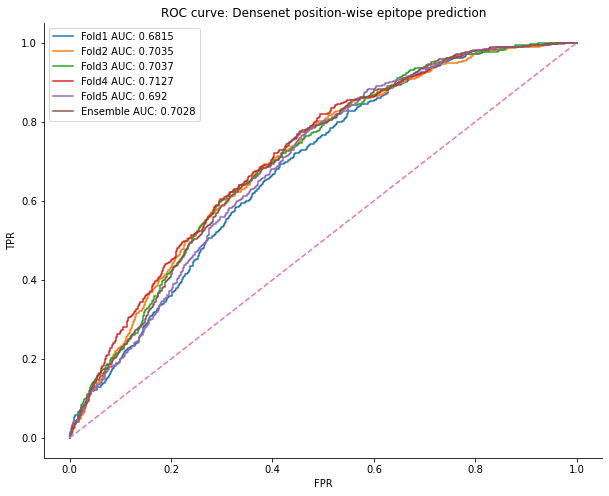

Concatenated all model predictions AUC: 0.6966100118452621
Concatenated all model predictions AUC10: 0.11805504262561763
Concatenated all model predictions MCC: 0.21995698069966604
Concatenated all model predictions recall 0.6579881656804734
Concatenated all model predictions precision: 0.288631251081502
Concatenated all model predictions F1 score: 0.40125090209285547
Concatenated all model predictions accuracy: 0.6271161048689139
Latex format: & 0.697 & 0.118 & 0.22 & 0.658 & 0.289 & 0.401 & 0.627
Average AUC across all models 0.699
Average AUC10 across all models 0.124
Average CE loss across all models 0.455
Average MCC across all models 0.222
Fold threshold values: [0.174, 0.136, 0.155, 0.136, 0.155]
Average positive recall across all models 0.658
Average precision across all models 0.289
Average F1-score across all models 0.398
Average accuracy across all models 0.627
Overfit threshold values [0.098, 0.12, 0.159, 0.127, 0.136]


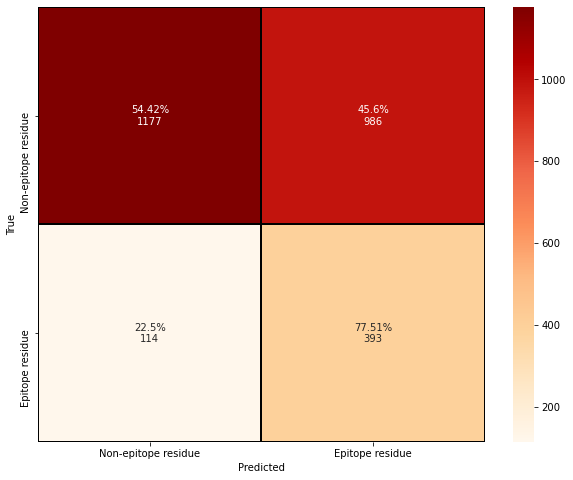

In [9]:
#Best on NewPDBDataESMEncodedCombinedClustered"
#plot_title = "ROC curve: LSTM position-wise epitope prediction"
plot_title = "ROC curve: Densenet position-wise epitope prediction"
#plot_title = "ROC curve: CNN position-wise epitope prediction with CNN"
#plot_title = "ROC curve: Position-wise epitope prediction with Densenet"


#model = MyDenseNet() #DensenetBP3ESMClus50ID
#model = MyDenseNet(esm_embedding_size=189,
#                               fc1_size=150,
#                               fc2_size=120,
#                               fc3_size=45)#DensenetBP3BlosumClus50ID"

#model = MyDenseNet(esm_embedding_size=189,
#                               fc1_size=150,
#                               fc2_size=120,
#                               fc3_size=64)  #DensenetBP3OneHotClus50ID"
#

#model = MyCNN1D() #CNNBP3ESMClus50ID
#model = MyCNN1D(esm_embedding_size=189,
#                cnn1d_filter_size=108,
#                cnn1d_kernel_dims= [5, 7]) #CNNBP3BlosumClus50ID
#model = MyCNN1D(esm_embedding_size=189,
#                cnn1d_filter_size=108,
#                cnn1d_kernel_dims= [3, 5]) #CNNBP3OneHotClus50ID
## NonHomRed
model = MyDenseNet() ##DensenetNonHomRedESM
#model = MyDenseNet(esm_embedding_size=189,
#                               fc1_size=150,
#                               fc2_size=120,
#                               fc3_size=64)  #DensenetNonHomRedBlosum
#model = model = MyDenseNet(esm_embedding_size=189,
#                               fc1_size=90,
#                               fc2_size=45,
#                               fc3_size=30)##DensenetNonHomRedOneHot

#model = MyCNN1D(cnn1d_filter_size=108, cnn1d_kernel_dims= [3, 5])#CNNBP3NonHomRedESM,
#model = MyCNN1D(esm_embedding_size=189,
#                cnn1d_filter_size=108,
#                cnn1d_kernel_dims= [3, 5]) # CNNBP3NonHomRedBlosum CNNBP3NonHomRedOneHot


### LSTM ###
#model = MyLSTM(esm_embedding_size=189) #Blosum and One Hot encodings
#model = MyLSTMExperiment() # ESM embeddings

#Experiments 
#model = MyDenseNet(esm_embedding_size=1469) #ESMandBlosumDensenetClus50ID
#model = MyCNN1D(esm_embedding_size=1469) #"CNNBP3ESMBlosumClus50ID"
#model= MyLSTMExperiment(esm_embedding_size=1469, hidden_size=40)

##model = MyLSTMExperiment(hidden_size=75, fsel_ffn1= 360)
#
##model= MyLSTMExperiment(hidden_size=50,fsel_ffn1= 720)
#model = MyLSTMExperiment(hidden_size = 75,
#                 fsel_ffn1 = 640,
#                 ffn1_size = 84)
#



#model = MyDenseNet(1281) #ESMClus50IDandSeqLen 

_, _ = evaluate_models_with_roc_curve(model, best_ce_loss_models, best_mcc_thresholds,  test_set_loader, plot_title, FIGURE_DIR / "roc_curve" )




# Test Eval Performance on individual proteins

Protein name: 2xwt_C
Fold1
AUC10: 0.2926
Neg. log. likelihood loss: 0.3578 Accuracy: 0.7521 MCC: 0.3237
Positive recall: 0.6470588235294118 Precision: 0.3235 F1-score: 0.4314
Accuaracy, recall and precision on top-20 assigned highest pos. prob
Accuracy: 0.5
Recall: 1.0
Precision: 0.5
Top seq idx: [11, 88, 22, 85, 56, 18, 81, 10, 86, 83, 21, 12, 159, 13, 58, 111, 67, 41, 34, 3]
Seq idx:11 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:88 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:22 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:85 Pred:Epitope residue, Label:Epitope residue
Seq idx:56 Pred:Epitope residue, Label:Epitope residue
Seq idx:18 Pred:Epitope residue, Label:Epitope residue
Seq idx:81 Pred:Epitope residue, Label:Epitope residue
Seq idx:10 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:86 Pred:Epitope residue, Label:Epitope residue
Seq idx:83 Pred:Epitope residue, Label:Epitope residue
Seq idx:21 Pred:Epitope residue, Label:Non-epitope res

C:\Users\Joaki\AppData\Local\Temp/ipykernel_17148/2577431012.py:95: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X_test = np.asarray(X_test_to_eval, dtype="object")


Ensemble AUC10 0.2853 Neg. log likelihood loss: 0.3532 Accuracy: 0.6624 MCC: 0.3595
Positive recall: 0.8824 Precision: 0.2857 F1-score: 0.4317 when using optimized threshold
Accuaracy, recall and precision on top-20 assigned highest pos. prob
Accuracy: 0.45
Recall: 1.0
Precision: 0.45
Top seq idx: [88, 11, 22, 85, 86, 111, 81, 12, 21, 18, 83, 56, 61, 37, 41, 171, 19, 10, 136, 188]
Seq idx:88 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:11 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:22 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:85 Pred:Epitope residue, Label:Epitope residue
Seq idx:86 Pred:Epitope residue, Label:Epitope residue
Seq idx:111 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:81 Pred:Epitope residue, Label:Epitope residue
Seq idx:12 Pred:Epitope residue, Label:Epitope residue
Seq idx:21 Pred:Epitope residue, Label:Non-epitope residue
Seq idx:18 Pred:Epitope residue, Label:Epitope residue
Seq idx:83 Pred:Epitope residue, Label:Epitop

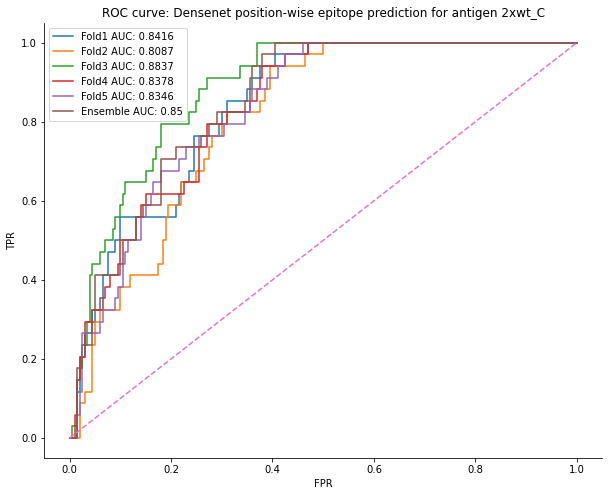

Concatenated all model predictions AUC: 0.8388941176470588
Concatenated all model predictions AUC10: 0.24994117647058825
Concatenated all model predictions MCC: 0.31665746136122874
Concatenated all model predictions recall 0.8352941176470589
Concatenated all model predictions precision: 0.2679245283018868
Concatenated all model predictions F1 score: 0.4057142857142857
Concatenated all model predictions accuracy: 0.6444444444444445
Latex format: & 0.839 & 0.25 & 0.317 & 0.835 & 0.268 & 0.406 & 0.644
Average AUC across all models 0.841
Average AUC10 across all models 0.267
Average CE loss across all models 0.354
Average MCC across all models 0.331
Fold threshold values: [0.174, 0.174, 0.116, 0.136, 0.155]
Average positive recall across all models 0.835
Average precision across all models 0.28
Average F1-score across all models 0.411
Average accuracy across all models 0.644
Overfit threshold values [0.156, 0.147, 0.171, 0.168, 0.142]
& 0.839 & 0.25 & 0.317 & 0.835 & 0.268 & 0.406 & 0.644


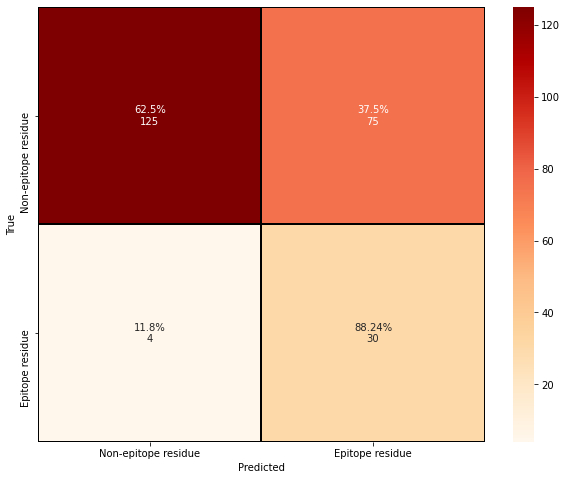

In [6]:
test_path = BEPIPRED3_CLUS50ID / "test.npz"
anno_path = BEPIPRED3_CLUS50ID_TEST_ANNO
#modeles
#model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3BlosumClus50ID" / "models"
#model_path =  RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESMClus50ID" / "models"
#model_path =  RESULTS_DIR / "NeuralNetworks" / "CNNBP3BlosumClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESMClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3BlosumClus50ID" / "models"
model_path = RESULTS_DIR / "NeuralNetworks" / "SeqlenDensenetBP3ESMClus50ID" / "models" 



#model architectures
#model = MyDenseNet()
model= MyDenseNet(1281)
#model = MyLSTMExperiment()
#model = MyCNN1D() 
#model = MyDenseNet(esm_embedding_size=189,
#                               fc1_size=150,
#                               fc2_size=120,
#                               fc3_size=45) #Blosum62 Clus50ID

#model = MyLSTM(esm_embedding_size=189) #Blosum or One Hot encodings
#model = MyCNN1D(esm_embedding_size=189,
#                cnn1d_filter_size=108,
#                cnn1d_kernel_dims= [5, 7]) #CNNBP3BlosumClus50ID

#experiments
#model_path =  RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMBlosumClus50ID" / "models"
#model_path  = RESULTS_DIR / "NeuralNetworks" / "CNNBP3ESMBlosumClus50ID" / "models"
#model_path = RESULTS_DIR / "NeuralNetworks" / "LSTMBP3ESMBlosumClus50ID" / "models"

#model = MyDenseNet(esm_embedding_size=1469) #ESMandBlosumDensenetClus50ID
#model = MyCNN1D(esm_embedding_size=1469) #"CNNBP3ESMBlosumClus50ID"
#model= MyLSTMExperiment(esm_embedding_size=1469, hidden_size=75)


overfit_test_proteins_thresholds = list()

#test_path = BEPIPRED3_CLUS50ID / "test.npz"
anno_path = BEPIPRED3_CLUS50ID_TEST_ANNO
best_ce_loss_models = list( model_path.glob("*bestCELoss*") )

best_mcc_thresholds = pickle.load(open(model_path / "best_mcc_threshold.pickle", "rb"))
accs_in_test_set = ["7lj4_B","4xak_A",
                    "4ypg_D", "7chz_I",
                    "5d8j_A", "3pnw_O",
                    "6y6c_A", "5f72_K",
                    "6u6u_R", "4qci_D",
                    "7jum_A", "5th9_A",
                    "6hga_B", "2xwt_C",
                    "6vtw_A"]


#accs_in_test_set = ["4xak_A", "7jum_A"]
#accs_in_test_set = ["7jum_A"]

#accs_in_test_set = ["4qci_D"]
#accs_in_test_set = ["7chz_I"]
#accs_in_test_set = ["5f72_K"]
accs_in_test_set = ["2xwt_C"]

latex_formats = str()
for acc_in_test_set in accs_in_test_set:
    plot_title = f"ROC curve: Densenet position-wise epitope prediction for antigen {acc_in_test_set}"
    print(f"Protein name: {acc_in_test_set}")
#    test_set_loader = prepare_test_set_loader(test_path, batch_size = 4,
#                                              accs_to_evaluate = [acc_in_test_set] )
    test_set_loader = prepare_test_set_loader(test_path, batch_size = 4,
                                              accs_to_evaluate = [acc_in_test_set],
                                              add_seq_len=True)

#    test_set_loader = prepare_test_set_loader(test_path, blosum_encode_path = anno_path,
#                                              batch_size=4, accs_to_evaluate = [acc_in_test_set])
#    test_set_loader = prepare_test_set_loader(test_path, blosum_encode_path = anno_path,
#                                              batch_size=4, accs_to_evaluate = [acc_in_test_set],
#                                             use_both_encodings=True)

    overfit_test_protein_thresholds, latex_format = evaluate_models_with_roc_curve(model, best_ce_loss_models,
                                                                     best_mcc_thresholds,
                                                                     test_set_loader, plot_title,
                                                                     FIGURE_DIR / "roc_curve",
                                                                    print_top_seq_idxs=True, num_top_preds_to_print=20)
    
    
    
    
    
    latex_formats += latex_format
    overfit_test_proteins_thresholds.append(overfit_test_protein_thresholds)
    
#print stuff for latex formatted tables
print(latex_formats[:-1])

In [134]:
#get average distance of optimized threshold for protein, to one used for entire test set
num_of_thresholds = len(overfit_test_proteins_thresholds[0])
avg_deltas = list()
for thresholds in overfit_test_proteins_thresholds:
    avg_delta = sum([abs(float(thresholds[i])-float(best_mcc_thresholds[i])) for i in range(num_of_thresholds)]) / num_of_thresholds
    avg_deltas.append(avg_delta)
    print(round(avg_delta,3))

[0.17448979591836736, 0.1357142857142857, 0.15510204081632653, 0.1357142857142857, 0.15510204081632653]
[[0.128, 0.167, 0.178, 0.129, 0.166], [0.134, 0.186, 0.195, 0.207, 0.22], [0.144, 0.17, 0.183, 0.174, 0.149], [0.107, 0.172, 0.195, 0.195, 0.185], [0.354, 0.148, 0.31, 0.3, 0.336], [0.147, 0.071, 0.073, 0.069, 0.087], [0.13, 0.258, 0.111, 0.222, 0.257], [0.06, 0.107, 0.086, 0.094, 0.103], [0.069, 0.12, 0.078, 0.123, 0.063], [0.339, 0.216, 0.328, 0.269, 0.358], [0.178, 0.219, 0.218, 0.248, 0.186], [0.048, 0.051, 0.039, 0.07, 0.058], [0.079, 0.113, 0.138, 0.13, 0.121], [0.189, 0.114, 0.24, 0.123, 0.213], [0.264, 0.265, 0.291, 0.295, 0.231]]
[0.06, 0.107, 0.086, 0.094, 0.103]
[0.069, 0.12, 0.078, 0.123, 0.063]
0.024
0.053
0.027
0.047
0.138
0.062
0.08
0.061
0.061
0.151
0.059
0.098
0.035
0.038
0.118


# Other Analysis

[WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold1_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold2_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold3_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold4_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetBP3ESMClus50ID/models/Fold5_bestCELoss')]
[0.17448979591836736, 0.1357142857142857, 0.15510204081632653, 0.1357142857142857, 0.15510204081632653]


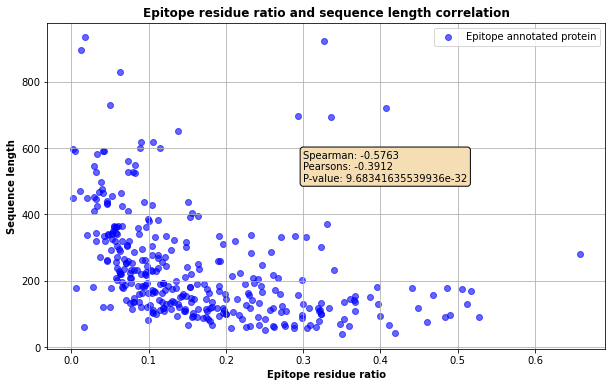

In [30]:
def generate_sorted_by_num_of_pos_anno_preds(model, model_states, best_mcc_thresholds, dataset, blosum_encode_path=None,
                                             one_hot_encode_path=None, add_seq_len=False):
    
    #go through each fold
    fold_paths = list( dataset.glob("*Fold*") )
    criterion = CrossEntropyLoss(ignore_index = 2)
    num_of_folds = len(fold_paths)
    fold_results = list()
    
    for i in range(num_of_folds):
        fold_path = fold_paths[i]
        opt_thresh = best_mcc_thresholds[i]
        model_state = model_states[i]
        print(f"Fold {i+1} / {num_of_folds}")
        print(f"Loading data from {str(fold_path)}")
        _, valid_loader, _ , _, _, _ = prepare_train_and_valid_loaders(fold_path,
                                                                            batch_size=1,
                                                                            shuffle_batches=False,
                                                                            blosum_encode_path=blosum_encode_path,
                                                                            one_hot_encode_path=blosum_encode_path,
                                                                            add_seq_len=add_seq_len)
    
        val_ce_loss_scores = np.zeros(len(valid_loader))
        val_mcc_scores = np.zeros(len(valid_loader))
        val_auc_scores = np.zeros(len(valid_loader))
        val_auc10_scores = np.zeros(len(valid_loader))
        val_overfit_threshs = np.zeros(len(valid_loader))
        val_seq_lens = np.zeros(len(valid_loader))
        
        val_pos_epi_ratios = np.zeros(len(valid_loader))        
        model.load_state_dict(torch.load(model_state))
        model.eval()
        j = 0
        
        val_model_outputs = list()
        val_all_labels = list()
        
        for data, labels in valid_loader:
            output= model(data)
            val_model_outputs.append(output)
            labels = torch.flatten(labels)
            val_all_labels.append(labels)
#            labels = torch.flatten(labels)
            count_anno = torch.bincount(labels)
            pos_epi_count, total_count = (count_anno[1], count_anno[0] + count_anno[1])
            pos_epi_ratio = pos_epi_count / total_count
            model_loss = criterion(output, labels)
            
            y_true, y_pos_prob = get_labels_preds_and_posprob_without_padding(output, labels)
            fpr, tpr, auc, overfit_thresh  = get_fpr_tpr_auc_and_opt_threshold(y_true, y_pos_prob)
            auc10 = compute_auc10(fpr, tpr)
            acc, mcc, recall, precision, f1_score, predictions = metrics_with_threshold(y_true, y_pos_prob, opt_thresh)
            
            
            val_pos_epi_ratios[j] = pos_epi_ratio
            val_ce_loss_scores[j] = model_loss
            val_mcc_scores[j] = mcc
            val_auc_scores[j] = auc
            val_auc10_scores[j] = auc10
            val_overfit_threshs[j] = overfit_thresh
            val_seq_lens[j] = total_count
            
            j += 1
            
        val_model_outputs = torch.cat(val_model_outputs, axis=0)
        val_all_labels = torch.cat(val_all_labels, axis=0)
        _, val_auc, val_mcc, val_mcc_threshold = get_performance_metrics(val_model_outputs, val_all_labels)
        print(f"Overall Validation MCC for fold: {round(val_mcc,4)}, using threshold of {round(val_mcc_threshold,4)}")
        print(f"Overall validation AUC for fold: {round(val_auc,4)}")
       

        fold_results.append((val_pos_epi_ratios, val_ce_loss_scores,
                             val_mcc_scores, val_auc_scores, val_auc10_scores,
                             val_overfit_threshs, val_seq_lens))
    
    
    val_pos_epi_ratios = np.concatenate([fold_result[0] for fold_result in fold_results])
    val_ce_loss_scores = np.concatenate([fold_result[1] for fold_result in fold_results])
    val_mcc_loss_scores = np.concatenate([fold_result[2] for fold_result in fold_results])
    val_auc_loss_scores = np.concatenate([fold_result[3] for fold_result in fold_results])
    val_auc10_loss_scores = np.concatenate([fold_result[4] for fold_result in fold_results])
    val_overfit_threshs = [fold_result[5] for fold_result in fold_results]
    val_seq_lens = np.concatenate([fold_result[6] for fold_result in fold_results])
    
    return (val_pos_epi_ratios,
            val_ce_loss_scores,
            val_mcc_loss_scores,
            val_auc_loss_scores,
            val_auc10_loss_scores,
            val_overfit_threshs,
            val_seq_lens)


def correlation_plot(pos_epi_ratios,
                     loss_scores,
                     file_name,
                     title="Epitope residue ratio and loss score correlation",
                     x_name = "Epitope residue ratio",
                     y_name="CE loss",
                     legend_name="Epitope annotated protein",
                     draw_fitted_line = False):
    
    spearman = stats.spearmanr(pos_epi_ratios, loss_scores)
    scc = spearman[0]
    pval = spearman[1]
    pcc = stats.pearsonr(pos_epi_ratios, loss_scores)[0]
    fig = plt.subplots(figsize =(10, 6))
    opacity = 0.6

    plt.scatter(pos_epi_ratios, loss_scores, color="b", alpha = opacity, label=legend_name)
   
    if draw_fitted_line:
        x, y = pos_epi_ratios.reshape(-1,1), loss_scores.reshape(-1,1)
        y_pred = LinearRegression().fit(x, y).predict(x)
        r2 = r2_score(y, y_pred)
        plt.plot(x, y_pred, label=f"Linear regression R2-score: {r2}")
    
    plt.grid()
    plt.title(title, fontweight='bold')
    plt.xlabel(x_name, fontweight='bold')
    plt.ylabel(y_name, fontweight='bold')
    plt.legend()
    props = dict(boxstyle='round', facecolor='wheat')
    
#    plt.text(0.45, 0.45, f"Spearman: {round(scc,4)}\nPearsons: {round(pcc,4)}\nP-value: {pval}",
#             bbox=props)
    plt.text(0.3, 500, f"Spearman: {round(scc,4)}\nPearsons: {round(pcc,4)}\nP-value: {pval}",
             bbox=props)
    file_dir = file_name.parent
    if not file_dir.is_dir():
        file_dir.mkdir(parents=True)
    
    plt.savefig(file_name, dpi = 500, bbox_inches='tight')
    plt.show()
    

model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetBP3ESMClus50ID" / "models"
model = MyDenseNet()
#model_path = RESULTS_DIR / "NeuralNetworks" / "SeqlenDensenetBP3ESMClus50ID" / "models"
#model= MyDenseNet(1281)

best_ce_loss_models = list( model_path.glob("*bestCELoss*") )
best_mcc_thresholds = pickle.load(open(model_path / "best_mcc_threshold.pickle", "rb"))

print(best_ce_loss_models)
print(best_mcc_thresholds)

#scores = generate_sorted_by_num_of_pos_anno_preds(model, best_ce_loss_models,
#                                                  best_mcc_thresholds, BEPIPRED3_CLUS50ID)
#scores = generate_sorted_by_num_of_pos_anno_preds(model, best_ce_loss_models,
#                                                  best_mcc_thresholds, BEPIPRED3_CLUS50ID, add_seq_len=True)

#num_of_dp = len(scores[0])
#val_pos_epi_ratios = scores[0]
#val_loss_scores = scores[1]
#val_mcc_loss_scores = scores[2]
#val_auc_loss_scores = scores[3]
#val_auc10_loss_scores = scores[4]
#val_overfit_threshs = scores[5]
#val_seq_lens = scores[6]
#
#val_seq_lens = np.concatenate(val_seq_lens)
#
#val = len([val_auc_loss_scores[i] for i in range(num_of_dp) if val_auc_loss_scores[i] >= 0.6 and val_pos_epi_ratios[i] <= 0.2])
#print(f"Proteins with AUC score above 0.6 and positive epitope ratio between 0 and 0.2: {val}")
#print(f"Proteins with AUC above 0.5 {len([auc for auc in val_auc_loss_scores if auc >= 0.5])} out of {num_of_dp}")
#print(f"Proteins with AUC above 0.6 {len([auc for auc in val_auc_loss_scores if auc >= 0.6])} out of {num_of_dp}")
#print(f"Proteins with AUC above 0.7 {len([auc for auc in val_auc_loss_scores if auc >= 0.7])} out of {num_of_dp}")
#print(f"Proteins with AUC above 0.75 {len([auc for auc in val_auc_loss_scores if auc >= 0.75])} out of {num_of_dp}")

### CE LOSS ###
#correlation_plot(val_pos_epi_ratios, val_loss_scores, FIGURE_DIR / "CEAndEpiRatioCor", draw_fitted_line = True)
#### MCC ###
#correlation_plot(val_pos_epi_ratios, val_mcc_loss_scores, FIGURE_DIR / "MCCAndEpiRatioCor", y_name = "MCC")
#### AUC ###
#correlation_plot(val_pos_epi_ratios, val_auc_loss_scores, FIGURE_DIR / "AUCAndEpiRatioCor", y_name = "AUC")
#### AUC10 ###
#correlation_plot(val_pos_epi_ratios, val_auc10_loss_scores, FIGURE_DIR / "AUC10AndEpiRatioCor", y_name = "AUC10")
### Sequence lengths ###
correlation_plot(val_pos_epi_ratios, val_seq_lens, FIGURE_DIR / "SeqLenAndEpiRatioCor", y_name = "Sequence length", title="Epitope residue ratio and sequence length correlation")

# Old Code and testing

In [20]:
import torch
from torch import nn

a = torch.randn(3, 1280, 300)  # Batch_size, embedding_size, sequence length 
m = nn.Conv1d(1280, 60, 9, padding="same")  # embedding_size, out_channels, kernel_size
out = m(a)
        
#  def masking(self, original_lengths, seq_len):
#      #creating masks
#      masks = []
#      for original_length in original_lengths:
#          num_of_paddings = seq_len - original_length
#          if num_of_paddings > 0:
#              mask = torch.cat([torch.ones(original_length), torch.zeros(num_of_paddings)]) 
#          elif num_of_paddings == 0:
#              mask = torch.ones(original_length)
#          else:
#              print("Something weird in the masking.")
#          masks.append(mask)
#      return masks

#        masks = self.masking(original_lengths, seq_len)



#def get_correlation_coefficents(fold_results):
#    """
#    Inputs: fold_results: [( fold1val_pos_epi_ratios, fold1val_loss_scores)...]
#    """
#    
##    train_spearman_coefficents = list()
##    train_p_values = list()
##    train_pearson_coefficients = list()
##    val_spearman_coefficents = list()
##    val_p_values = list()
##    val_pearson_coefficients = list()
#    
##    num_of_folds = len(fold_results)
#    
#    val_pos_epi_ratios = [fold_result[0] for fold_result in fold_results]
#    val_pos_epi_ratios = np.concatenate(val_pos_epi_ratios)
#    val_loss_scores = [fold_result[1] for fold_result in fold_results]
#    val_loss_scores = np.concatenate(val_loss_scores)
#    
#    #get 
#    val_stats = stats.spearmanr(val_pos_epi_ratios, val_loss_scores)
#    
#    val_scc = val_stats[0]
#    val_pval = val_stats[1]
#    val_pcc = stats.pearsonr(val_pos_epi_ratios, val_loss_scores)[0]
#    
#    print(f"Spear. coef:{round(val_scc ,5)}, Pearson coef: {round(val_pcc,5)}, P-value: {val_pval}")
#
#    
#    
##    for i in range(num_of_folds):
##        fold_result = fold_results[i]
###        train_pos_epi_ratios = fold_result[0]
###        train_loss_scores =  fold_result[1]
##        val_pos_epi_ratios =  fold_result[0]
##        val_loss_scores =  fold_result[1]
##        
###        train_stats = stats.spearmanr(train_pos_epi_ratios, train_loss_scores)
##        val_stats = stats.spearmanr(val_pos_epi_ratios, val_loss_scores)
##        
###        train_spearman_coefficents.append(train_stats[0])
###        train_pearson_coefficients.append(stats.pearsonr(train_pos_epi_ratios, train_loss_scores)[0])
###        train_p_values.append(train_stats[1])
##       
##        
##        val_spearman_coefficents.append(val_stats[0])
##        val_pearson_coefficients.append(stats.pearsonr(val_pos_epi_ratios, val_loss_scores)[0])
##        val_p_values.append(val_stats[1])
##    
##    
##    for i in range(num_of_folds):
###        train_spc = train_spearman_coefficents[i]
###        train_pcc = train_pearson_coefficients[i]
###        train_pval = train_p_values[i]
##        
##        val_spc = val_spearman_coefficents[i]
##        val_pcc = val_pearson_coefficients[i]
##        val_pval = val_p_values[i]
##        
##        print(f"On train, Fold{i+1}: Spear. coef:{round(train_spc,5)}, Pearson coef: {round(train_pcc,5)}, P-value: {train_pval}")
##        print(f"On validation, Fold{i+1}: Spear. coef:{round(val_spc,5)}, Pearson coef: {round(val_pcc,5)}, P-value: {val_pval}")
##    
##    
##    return (train_spearman_coefficents,
##            train_pearson_coefficients,
#            train_p_values,
#            val_spearman_coefficents,
#            val_pearson_coefficients,
#            val_p_values)
#

#def barplot_of_epitope_ratios_to_loss_scores(fold_results, barplot_max_bin = 0.61, bar_bin_interval=0.025):
#    
#    """
#    
#    """
#    
#    
#    
#    fig = plt.subplots(figsize =(10, 6))
#    width = 0.3
#    opacity = 0.6
#    labels = ["Train", "Val"]
#    width = 0.15
#    colors = [(234/255, 15/255, 15/255), (234/255, 97/255, 15/255)]
#    
#    num_of_folds = len(fold_results)
#    all_train_epi_ratios = list()
#    all_train_loss_scores = list()
#    all_val_epi_ratios = list()
#    all_val_loss_scores = list()
#    barplot_bins = np.arange(bar_bin_interval, barplot_max_bin, bar_bin_interval, dtype="object").tolist()
#    barplot_bins = [round(barplot_bin, 3) for barplot_bin in barplot_bins]
#    
#    for i in range(num_of_folds):
#        fold_result = fold_results[i]
#        train_pos_epi_ratios = fold_result[0].tolist()
#        train_loss_scores =  fold_result[1].tolist()
#        val_pos_epi_ratios =  fold_result[2].tolist()
#        val_loss_scores =  fold_result[3].tolist()
#        
#        all_train_epi_ratios.extend(train_pos_epi_ratios)
#        all_train_loss_scores.extend(train_loss_scores)
#        all_val_epi_ratios.extend(val_pos_epi_ratios)
#        all_val_loss_scores.extend(val_loss_scores )
#    
#    #sort from min to max
#    train_epi_ratios_and_loss_scores = sorted(zip(all_train_epi_ratios, all_train_loss_scores), key=lambda pair: pair[0])
#    val_epi_ratios_and_loss_scores = sorted(zip(all_val_epi_ratios, all_val_loss_scores), key=lambda pair: pair[0])
#    
#    
#    all_train_epi_ratios = [val[0] for val in train_epi_ratios_and_loss_scores]
#    all_train_loss_scores = [val[1] for val in train_epi_ratios_and_loss_scores]
#    all_val_epi_ratios = [val[0] for val in val_epi_ratios_and_loss_scores]
#    all_val_loss_scores = [val[1] for val in val_epi_ratios_and_loss_scores]
#    
#    #get indices to slice at
#    i=0
#    idx_slices = [0]
#    avg_train_bin_loss_scores = list()
#    avg_val_bin_loss_scores = list()
#
#    for barplot_bin in barplot_bins:
#        epi_ratio = all_train_epi_ratios[i]
#        while barplot_bin > epi_ratio:
#            i += 1
#            epi_ratio = all_train_epi_ratios[i]
#        
#        idx_slices.append(i)
#        loss_score_bin = all_train_loss_scores[idx_slices[-2]:idx_slices[-1]]
#        avg_loss_score_for_bin = sum(loss_score_bin) / len(loss_score_bin)
#        avg_train_bin_loss_scores.append(avg_loss_score_for_bin)
#        
#    
#    #get remaining stuff for last bin
#    loss_score_bin = all_train_loss_scores[idx_slices[-1] + 1:]
#    if not loss_score_bin:
#        avg_loss_score_for_bin.append(0)
#    else:
#        avg_loss_score_for_bin = sum(loss_score_bin) / len(loss_score_bin)
#        avg_train_bin_loss_scores.append(avg_loss_score_for_bin)
#    
#    i = 0 
#    idx_slices = [0]
#    for barplot_bin in barplot_bins:
#        
#        epi_ratio = all_val_epi_ratios[i]
#        while barplot_bin > epi_ratio:
#            i += 1
#            epi_ratio = all_val_epi_ratios[i]
#        
#        idx_slices.append(i)
#        loss_score_bin = all_val_loss_scores[idx_slices[-2]:idx_slices[-1]]
#        avg_loss_score_for_bin = sum(loss_score_bin) / len(loss_score_bin)
#        avg_val_bin_loss_scores.append(avg_loss_score_for_bin)
#        
#    #get remaining stuff for last bin if needed
#    loss_score_bin = all_val_loss_scores[idx_slices[-1] + 1:]
#    if not loss_score_bin:
#        avg_val_bin_loss_scores.append(0)
#    else:
#        avg_loss_score_for_bin = sum(loss_score_bin) / len(loss_score_bin)
#        avg_val_bin_loss_scores.append(avg_loss_score_for_bin)
#    
#    barplot_bins = np.append(barplot_bins, f">{barplot_bins[-1]}")
#    
#    idx = np.arange(len(barplot_bins))
#    barplot1 = plt.bar(idx,  avg_val_bin_loss_scores , width, color=colors[0], alpha = opacity, label=labels[0])
#    idx = [x + width for x in idx]
#    barplot2 = plt.bar(idx,  avg_train_bin_loss_scores, width, color=colors[1], alpha = opacity, label=labels[1])
#    
#    plt.ylabel("Cross entropy loss")
#    plt.title("Cross entropy loss for proteins with different epitope ratios")
#    plt.xticks(idx, barplot_bins, fontsize=6)
#    plt.xlabel("Epitope residue ratios")
#    plt.legend()
#    
#    plt.show()

#  def masking(self, original_lengths, seq_len):
#       #creating masks
#       masks = []
#       for original_length in original_lengths:
#           num_of_paddings = seq_len - original_length
#           if num_of_paddings > 0:
#               mask = torch.cat([torch.ones(original_length), torch.zeros(num_of_paddings)]) 
#           elif num_of_paddings == 0:
#               mask = torch.ones(original_length)
#           else:
#               print("Something weird in the masking.")
#           masks.append(mask)
#       return masks
#   


torch.Size([3, 60, 300])
Conv1d(1280, 60, kernel_size=(9,), stride=(1,), padding=same)


In [49]:
test = torch.tensor([[2.0,2.0,3.0], [2.0,2.0,3.0]])
print(torch.mean(test, axis=0))

tensor([2., 2., 3.])


In [69]:
test = [torch.tensor([1.0,2.0,3.0]), torch.tensor([4.0,5.0,6.0])]

In [74]:
torch.stack(test, axis=0)

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [124]:
test = [torch.tensor([[1,2], [3,4]]), torch.tensor([[5,6], [7,8]])]
print(test)

[tensor([[1, 2],
        [3, 4]]), tensor([[5, 6],
        [7, 8]])]


In [126]:
test3 = torch.stack(test, axis=1).float()
print(test3)
torch.mean(test3, axis=1)

tensor([[[1., 2.],
         [5., 6.]],

        [[3., 4.],
         [7., 8.]]])


tensor([[3., 4.],
        [5., 6.]])

In [101]:



#test2 = torch.cat(test, axis=0)

In [110]:
torch.tensor([[1,5], [2,6], [3,7], [4,8]])

tensor([[1, 5],
        [2, 6],
        [3, 7],
        [4, 8]])

In [ ]:
test = nn.Sequential(nn.Conv1d(esm_embedding_size, cnn1d_filter_size, cnn1d_kernel_dims[0], padding="same"),
                                      nn.ReLU())

#reshape to CNN dimensions (N, sequence_length, esm_embedding) --> (N, esm_embedding, sequence_length)
x = torch.random((3, 150, 1280))
cnn_input = 
cnn_input = x.permute(0,2,1) 
first_cnn_out = test(cnn_input)
#rearranging cnn outputs from (N, filter_size, sequence_length) --> (N, sequence_length, filter_size)
#then reshaping from (N, sequence_length, filter_size) --> (N*sequence_length, filter_size)
first_cnn_out = first_cnn_out.permute(0, 2, 1)


In [74]:
mcc_thresholds = [i for i in range(0, 3, 1)]

In [9]:
test1 = np.asarray([torch.randn((250, 1280)), torch.randn((150, 1280)) ])
test2 = np.asarray([torch.randn((100, 1280)), torch.randn((330, 1280)) ])

<ipython-input-9-78f7b67a8bc9>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  test1 = np.asarray([torch.randn((250, 1280)), torch.randn((150, 1280)) ])
<ipython-input-9-78f7b67a8bc9>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test1 = np.asarray([torch.randn((250, 1280)), torch.randn((150, 1280)) ])
<ipython-input-9-78f7b67a8bc9>:2: FutureWarning: The input o

In [15]:
test3 = np.concatenate((test1, test2))
print(test1)
print(test2)

[tensor([[ 1.0970,  1.8734,  0.0889,  ...,  0.7151, -0.1664,  0.1911],
         [-0.0700, -0.0715,  1.1818,  ...,  0.6899, -0.2051, -1.7565],
         [ 1.3364,  1.0326,  0.3783,  ..., -0.3620,  0.2764,  1.7756],
         ...,
         [ 0.1975,  0.4843,  0.2943,  ..., -0.0179, -0.9231,  1.5429],
         [-0.7774, -1.8605, -1.3863,  ...,  0.6429,  0.2769, -0.5838],
         [-0.6181, -0.5328,  0.2535,  ...,  0.7219, -0.7044, -0.3333]])
 tensor([[-0.8157, -1.2719, -2.2686,  ...,  0.2744,  1.4862, -0.8444],
         [-0.5622, -0.0042, -1.0886,  ..., -0.8664,  0.2106, -1.8423],
         [ 0.0648,  0.1180,  2.4690,  ...,  0.6799,  0.3502,  0.9394],
         ...,
         [-0.3224, -0.8435, -2.3758,  ..., -1.5335, -0.1179,  1.1276],
         [-0.6787,  2.9058, -0.1418,  ...,  0.9161, -0.5362,  0.4679],
         [ 0.6079,  0.3204, -1.0255,  ...,  0.0230,  2.2480, -1.4440]])]
[tensor([[-1.6668,  0.4738,  1.5440,  ..., -0.1660,  1.1033,  0.5430],
         [-0.0881,  0.1207, -0.1030,  ...,  0.

In [16]:
print(test3)

[tensor([[ 1.0970,  1.8734,  0.0889,  ...,  0.7151, -0.1664,  0.1911],
         [-0.0700, -0.0715,  1.1818,  ...,  0.6899, -0.2051, -1.7565],
         [ 1.3364,  1.0326,  0.3783,  ..., -0.3620,  0.2764,  1.7756],
         ...,
         [ 0.1975,  0.4843,  0.2943,  ..., -0.0179, -0.9231,  1.5429],
         [-0.7774, -1.8605, -1.3863,  ...,  0.6429,  0.2769, -0.5838],
         [-0.6181, -0.5328,  0.2535,  ...,  0.7219, -0.7044, -0.3333]])
 tensor([[-0.8157, -1.2719, -2.2686,  ...,  0.2744,  1.4862, -0.8444],
         [-0.5622, -0.0042, -1.0886,  ..., -0.8664,  0.2106, -1.8423],
         [ 0.0648,  0.1180,  2.4690,  ...,  0.6799,  0.3502,  0.9394],
         ...,
         [-0.3224, -0.8435, -2.3758,  ..., -1.5335, -0.1179,  1.1276],
         [-0.6787,  2.9058, -0.1418,  ...,  0.9161, -0.5362,  0.4679],
         [ 0.6079,  0.3204, -1.0255,  ...,  0.0230,  2.2480, -1.4440]])
 tensor([[-1.6668,  0.4738,  1.5440,  ..., -0.1660,  1.1033,  0.5430],
         [-0.0881,  0.1207, -0.1030,  ...,  0.0

In [10]:
torch.bincount(torch.tensor([0,1,0,1,0,4]))

tensor([3, 2, 0, 0, 1])

In [26]:
test= stats.spearmanr([1,2,3,4,5], [5,6,7,8,7])
print(test)

SpearmanrResult(correlation=0.8207826816681233, pvalue=0.08858700531354381)


TypeError: tuple indices must be integers or slices, not str

In [70]:
float("9.502840796111183e-39")

9.502840796111183e-39

In [76]:
round(9.502840796111183e-39,)

9.5e-39

In [25]:
-math.log(0.514091041904910941)

0.6653549048830133

In [25]:

inputs = torch.randn(4, 200, 1280)
inputs = inputs.permute(0, 2, 1)
cnn1d = nn.Conv1d(1280, 45, 3, padding="same")
cnn_out = cnn1d(inputs)
print(cnn_out.size())

output = mp1d(cnn_out)
print(output.size())

torch.Size([4, 45, 200])
torch.Size([4, 200, 22])


In [ ]:
train_loader, valid_loader, _, _, _, _ = prepare_train_and_valid_loaders(BEPIPRED3_CLUS50ID / "Fold1.npz", batch_size = 4,
                                                                         shuffle_batches=True,
                                                                         blosum_encode_path=BEPIPRED3_CLUS50ID_ANNO,
                                                                         use_both_encodings=True)

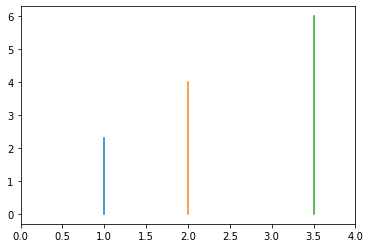

In [36]:
import matplotlib.pyplot as plt
points = [ (1.,2.3), (2.,4.), (3.5,6.) ] # (a1,b1), (a2,b2), ...

#plt.hold(True)
plt.xlim(0,4)  # set up the plot limits

for pt in points:
    # plot (x,y) pairs.
    print(pt[0])
    print()
    # vertical line: 2 x,y pairs: (a,0) and (a,b)
    plt.plot( [pt[0],pt[0]], [0,pt[1]] )

plt.show()

In [91]:
mcc_thresholds = np.linspace(0, 0.95, 50)

In [92]:
mcc_thresholds

array([0.        , 0.01938776, 0.03877551, 0.05816327, 0.07755102,
       0.09693878, 0.11632653, 0.13571429, 0.15510204, 0.1744898 ,
       0.19387755, 0.21326531, 0.23265306, 0.25204082, 0.27142857,
       0.29081633, 0.31020408, 0.32959184, 0.34897959, 0.36836735,
       0.3877551 , 0.40714286, 0.42653061, 0.44591837, 0.46530612,
       0.48469388, 0.50408163, 0.52346939, 0.54285714, 0.5622449 ,
       0.58163265, 0.60102041, 0.62040816, 0.63979592, 0.65918367,
       0.67857143, 0.69795918, 0.71734694, 0.73673469, 0.75612245,
       0.7755102 , 0.79489796, 0.81428571, 0.83367347, 0.85306122,
       0.87244898, 0.89183673, 0.91122449, 0.93061224, 0.95      ])

tensor([69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69.,
        69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69.,
        69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69.,
        69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69.,
        69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69., 69.])

tensor([[69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [69.],
        [6

In [27]:
print(test.size())

torch.Size([69, 1281])


In [29]:
print(test[:,1279])

tensor([0.8382, 0.9597, 0.1672, 0.5095, 0.0136, 0.4569, 0.3098, 0.1684, 0.6506,
        0.8732, 0.8344, 0.4067, 0.4906, 0.9492, 0.6682, 0.8044, 0.0559, 0.7574,
        0.5110, 0.2306, 0.2382, 0.3872, 0.3322, 0.6882, 0.2176, 0.4813, 0.7405,
        0.9339, 0.2162, 0.5192, 0.1433, 0.7843, 0.3380, 0.0850, 0.3438, 0.6189,
        0.6601, 0.7216, 0.4121, 0.7771, 0.2613, 0.1979, 0.1543, 0.5392, 0.1628,
        0.5742, 0.4812, 0.1247, 0.0263, 0.1406, 0.5986, 0.6548, 0.8259, 0.4212,
        0.4248, 0.1758, 0.3632, 0.9255, 0.9840, 0.2052, 0.2633, 0.9332, 0.7326,
        0.0993, 0.0694, 0.8093, 0.4626, 0.9011, 0.9037])


In [23]:
### For PyMOL prediction comparisions (SeqlenDensenetBP3ESMClus50ID model) ###

print(">4qci_D")
print("iaepamiaecktrtevfeisrrlidrtnanfLVWppcvevqrcsgccNnRnvqcrptqvqlrpvQvRkIEIvRKKPIFKKatvtledhlackcetv")
lower_seq = "iaepamiaecktrtevfeisrrlidrtnanfLVWppcvevqrcsgccNnRnvqcrptqvqlrpvQvRkIEIvRKKPIFKKatvtledhlackcetv".lower()
top_20_idxs = [73, 74, 75, 25, 72, 49, 21, 54, 76, 50, 66, 79, 78, 20, 12, 77, 83, 52, 17, 29]
seq_with_pred_epitopes = "".join([AA.upper() if idx in top_20_idxs else AA.lower() for idx, AA in enumerate(lower_seq)])
print(">4qci_D_pred")
print(seq_with_pred_epitopes)

print(">7chz_I")
print("pvrslnctlrdsQqkslVMSGPYElKaLHLQgQDmEQQvVfsmsfvqgeesndkipvalglkEKNLylscVLKDdkptlQLESVDPKNYpKkKmEKRfvfnkieinnklefesAQFPnwyistsQAENMPvflggtkgGQditdftmqfvss")
lower_seq = "pvrslnctlrdsQqkslVMSGPYElKaLHLQgQDmEQQvVfsmsfvqgeesndkipvalglkEKNLylscVLKDdkptlQLESVDPKNYpKkKmEKRfvfnkieinnklefesAQFPnwyistsQAENMPvflggtkgGQditdftmqfvss".lower()
top_20_idxs = [127, 73, 126, 75, 74, 12, 63, 128, 51, 72, 21, 64, 49, 23, 48, 22, 125, 79, 62, 50]
seq_with_pred_epitopes = "".join([AA.upper() if idx in top_20_idxs else AA.lower() for idx, AA in enumerate(lower_seq)])
print(">7chz_I_pred")
print(seq_with_pred_epitopes)

print(">5f72_K")
print("grliytaggYfrqslsyleaYnPSDGtwldladlqvprSglagcvvggllyavggRnNspDgNtdssaldcynpmtnqwspcapmsvprnRigvgvidghiyavggshgCiHhnsveryeperdewhlvapmltrrigvgvavlnrllyavggFdGTnRlnsaecyypernewrmitamntirSGagvcvlhnciyaaggYdGQdQlnsverydvetetwtfvapmkhrrSAlgitvhqgRiyvlggYDGHtFldsvecyDpdtdtwsevTRmtsgrSgvgvavt")
lower_seq = "grliytaggYfrqslsyleaYnPSDGtwldladlqvprSglagcvvggllyavggRnNspDgNtdssaldcynpmtnqwspcapmsvprnRigvgvidghiyavggshgCiHhnsveryeperdewhlvapmltrrigvgvavlnrllyavggFdGTnRlnsaecyypernewrmitamntirSGagvcvlhnciyaaggYdGQdQlnsverydvetetwtfvapmkhrrSAlgitvhqgRiyvlggYDGHtFldsvecyDpdtdtwsevTRmtsgrSgvgvavt".lower()
top_20_idxs = [60, 204, 157, 12, 59, 11, 110, 113, 62, 254, 207, 250, 251, 160, 134, 61, 122, 16, 203, 63]
seq_with_pred_epitopes = "".join([AA.upper() if idx in top_20_idxs else AA.lower() for idx, AA in enumerate(lower_seq)])
print(">5f72_K_pred")
print(seq_with_pred_epitopes)

print(">2xwt_C")
print("cssppcechqeeDfRvtcKdiqripslppstQTlKlIEthlrtipshafsnlpnisRiYvSIdvtlqqleshsfynlskvTHiEiRNtrnltyidpdalkelpllKFlgiFntglkmfpdltkvystDIFfIlEitdnpymtsipvnafqglcnetlTlKlYnngftsvqgyafngtklDavylNKnkyltvidkdafggvysgpslldvsQtsvtalpskglehlkeliaRNt")
lower_seq = "cssppcechqeeDfRvtcKdiqripslppstQTlKlIEthlrtipshafsnlpnisRiYvSIdvtlqqleshsfynlskvTHiEiRNtrnltyidpdalkelpllKFlgiFntglkmfpdltkvystDIFfIlEitdnpymtsipvnafqglcnetlTlKlYnngftsvqgyafngtklDavylNKnkyltvidkdafggvysgpslldvsQtsvtalpskglehlkeliaRNt".lower()
top_20_idxs = [88, 11, 22, 85, 86, 111, 81, 12, 21, 18, 83, 56, 61, 37, 41, 171, 19, 10, 136, 188]
seq_with_pred_epitopes = "".join([AA.upper() if idx in top_20_idxs else AA.lower() for idx, AA in enumerate(lower_seq)])
print(">2xwt_C_pred")
print(seq_with_pred_epitopes)

>4qci_D
iaepamiaecktrtevfeisrrlidrtnanfLVWppcvevqrcsgccNnRnvqcrptqvqlrpvQvRkIEIvRKKPIFKKatvtledhlackcetv
>4qci_D_pred
iaepamiaecktRtevfEisRRlidRtnaNflvwppcvevqrcsgccnnRNvQcRptqvqlrpvqvRkieivRKKPIFKKatvTledhlackcetv
>7chz_I
pvrslnctlrdsQqkslVMSGPYElKaLHLQgQDmEQQvVfsmsfvqgeesndkipvalglkEKNLylscVLKDdkptlQLESVDPKNYpKkKmEKRfvfnkieinnklefesAQFPnwyistsQAENMPvflggtkgGQditdftmqfvss
>7chz_I_pred
pvrslnctlrdsQqkslvmsgPYElkalhlqgqdmeqqvvfsmsfvqgEESNdkipvalglkEKNlylscvlKDDKptlQlesvdpknypkkkmekrfvfnkieinnklefesaqfpnwyistsqAENMpvflggtkggqditdftmqfvss
>5f72_K
grliytaggYfrqslsyleaYnPSDGtwldladlqvprSglagcvvggllyavggRnNspDgNtdssaldcynpmtnqwspcapmsvprnRigvgvidghiyavggshgCiHhnsveryeperdewhlvapmltrrigvgvavlnrllyavggFdGTnRlnsaecyypernewrmitamntirSGagvcvlhnciyaaggYdGQdQlnsverydvetetwtfvapmkhrrSAlgitvhqgRiyvlggYDGHtFldsvecyDpdtdtwsevTRmtsgrSgvgvavt
>5f72_K_pred
grliytaggyfRQslsYleaynpsdgtwldladlqvprsglagcvvggllyavggrnnsPDGNTdssaldcynpmtnqwspcapmsvprnrigvgvidghiyavggshgcIhhNsveryepeRdewhlvapmltRrigvgvavlnrllyav

In [25]:
test = "cssppcechqeeDfRvtcKdiqripslppstQTlKlIEthlrtipshafsnlpnisRiYvSIdvtlqqleshsfynlskvTHiEiRNtrnltyidpdalkelpllKFlgiFntglkmfpdltkvystDIFfIlEitdnpymtsipvnafqglcnetlTlKlYnngftsvqgyafngtklDavylNKnkyltvidkdafggvysgpslldvsQtsvtalpskglehlkeliaRNt"
print(len([t for t in test if t.isupper()]))

34


In [11]:
l

lpwlnvsadgdnvhlvlnvseeqhfglslywnqvqgppkprwhknltgpqiitlqhtdlvpclciqvwplepdsvrtnicpfredprahqnlwqaarlrlltlqswlldapcslpaeaalcwrapggdpcqplvpplsweqvtvdkvlefpllkghpnlcvqvqsseklqlqeclwadslgplkddvllletrgpqdqrslcalepsgctslpsKaStraaRLgEYllqdlqsgqclqlwdddlgalwacpmdkyihKREFRH


In [22]:
test="iaepamiaecktRtevfEisRRlidRtnaNflvwppcvevqrcsgccnnRNvQcRptqvqlrpvqvRkieivRKKPIFKKatvTledhlackcetv"
print(len([t for t in test if t.isupper()]))

20
